ML for Inverse Problems (Spring 2024) - Final Project

Universal Desnoising in Plug&Play Iterative Methods

Francis Moran - Ali Zafari

### Function/Model Definitions + Module Imports

In [ ]:
# Run on Colab Only

import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/Othercomputers/My Mac/MLIP')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!pip install bm3d

In [38]:
import json
import argparse
from tqdm import tqdm
from PIL import Image
from bm3d import bm3d

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.serialization import default_restore_location

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.dpi': 500
})

In [48]:
def psnr_mse(x, x_hat, x_max):
    n1, n2 = x.shape
    mse = np.linalg.norm(x - x_hat)**2 / (n1 * n2)
    return 10 * np.log10(x_max**2 / mse), mse


class BFBatchNorm2d(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, use_bias = False, affine=True):
        super(BFBatchNorm2d, self).__init__(num_features, eps, momentum)

        self.use_bias = use_bias;

    def forward(self, x):
        self._check_input_dim(x)
        y = x.transpose(0,1)
        return_shape = y.shape
        y = y.contiguous().view(x.size(1), -1)
        if self.use_bias:
            mu = y.mean(dim=1)
        sigma2 = y.var(dim=1)

        if self.training is not True:
            if self.use_bias:
                y = y - self.running_mean.view(-1, 1)
            y = y / ( self.running_var.view(-1, 1)**0.5 + self.eps)
        else:
            if self.track_running_stats is True:
                with torch.no_grad():
                    if self.use_bias:
                        self.running_mean = (1-self.momentum)*self.running_mean + self.momentum * mu
                    self.running_var = (1-self.momentum)*self.running_var + self.momentum * sigma2
            if self.use_bias:
                y = y - mu.view(-1,1)
            y = y / (sigma2.view(-1,1)**.5 + self.eps)

        if self.affine:
            y = self.weight.view(-1, 1) * y;
            if self.use_bias:
                y += self.bias.view(-1, 1)

        return y.view(return_shape).transpose(0,1)


class DnCNN(nn.Module):
    """DnCNN as defined in https://arxiv.org/abs/1608.03981
       reference implementation: https://github.com/SaoYan/DnCNN-PyTorch"""

    def __init__(self, depth=20, n_channels=64, image_channels=1, bias=False, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1

        self.bias = bias;
        if not bias:
            norm_layer = BFBatchNorm2d
        else:
            norm_layer = nn.BatchNorm2d
        self.depth = depth;

        self.first_layer = nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size,
                                     padding=padding, bias=self.bias)

        self.hidden_layer_list = [None] * (self.depth - 2);

        self.bn_layer_list = [None] * (self.depth - 2);

        for i in range(self.depth - 2):
            self.hidden_layer_list[i] = nn.Conv2d(in_channels=n_channels, out_channels=n_channels,
                                                  kernel_size=kernel_size, padding=padding, bias=self.bias);
            self.bn_layer_list[i] = norm_layer(n_channels)

        self.hidden_layer_list = nn.ModuleList(self.hidden_layer_list);
        self.bn_layer_list = nn.ModuleList(self.bn_layer_list);
        self.last_layer = nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size,
                                    padding=padding, bias=self.bias)

    @staticmethod
    def add_args(parser):
        """Add model-specific arguments to the parser."""
        parser.add_argument("--in-channels", type=int, default=1, help="number of channels")
        parser.add_argument("--hidden-size", type=int, default=64, help="hidden dimension")
        parser.add_argument("--num-layers", default=20, type=int, help="number of layers")
        parser.add_argument("--bias", action='store_true', help="use residual bias")

    @classmethod
    def build_model(cls, args):
        return cls(image_channels=args.in_channels, n_channels=args.hidden_size, depth=args.num_layers, bias=args.bias)

    def forward(self, x):
        y = x
        out = self.first_layer(x);
        out = F.relu(out);

        for i in range(self.depth - 2):
            out = self.hidden_layer_list[i](out);
            out = self.bn_layer_list[i](out);
            out = F.relu(out)

        out = self.last_layer(out);

        return y - out


def load_model(checkpoint_path, device='cpu'):
    state_dict = torch.load(checkpoint_path, map_location=lambda s, l: default_restore_location(s, "cpu"))
    args = argparse.Namespace(**{ **vars(state_dict["args"]), "no_log": True})

    model = DnCNN.build_model(args).to(device)
    model.load_state_dict(state_dict["model"][0])
    model.eval()
    return model


def measurement_matrix(mode, m, n):
    if mode == 'gaussian':
        S = np.random.normal(0, 1, (m, n))
    elif mode == 'dct':
        S = np.array([[np.cos(((np.pi * j) / n) * (i + 1/2) ) for i in range(n)] for j in range(m)])
    else:
        print('mode unknown.')
    A = S / np.linalg.norm(S, axis=0)
    return A


def cs_dncnn(PnP_iter, A_mode, mu, sigma, bias_free=False):

    np.random.seed(10)
    torch.manual_seed(1580)

    denoiser_name = 'bfdncnn' if bias_free else 'dncnn'
    PnP_iter = PnP_iter
    n = 64 * 64
    m_list = [int(n / 4), int(n / 2), int(3 * n / 4)]
    mu = mu  # gradient update step size
    sigma = sigma  # highest observed noise level in training of denoiser
    A_mode = A_mode  # 'gaussian' or 'dct'

    img = np.array(Image.open('test_image.tiff')) / 255.0
    x_loc, y_loc = 30, 120  # upper-left corner location
    patch = img[x_loc:x_loc + 64, y_loc:y_loc + 64]
    x = patch.reshape(n, 1)

    best_psnrs = []
    best_mses = []
    best_reconstructions = []

    if bias_free:
        path = f'pretrained/dncnn/bias_free/0-{int(sigma)}.pt'
    else:
        path = f'pretrained/dncnn/bias/0-{int(sigma)}.pt'
    denoiser = load_model(path)
    denoiser.eval()

    for j, m in enumerate(m_list):
        A = measurement_matrix(A_mode, m, n)
        y = A @ x
        x_hat = np.zeros((n, 1))
        psnr_best, mse_best, x_hat_best, iter_best = 0., 0., None, 0
        for p in (pbar := tqdm(range(PnP_iter))):
            s = x_hat + mu * (A.T @ (y - (A @ x_hat)))
            x_hat = denoiser(torch.Tensor(s.reshape(64, 64))[None, None, :, :]).squeeze().detach().numpy().reshape(n, 1)
            psnr_temp, mse_temp = psnr_mse(x, x_hat, 1)
            if psnr_temp > psnr_best:
                psnr_best = psnr_temp
                mse_best = mse_temp
                x_hat_best = x_hat
                iter_best = p
            pbar.set_postfix({'m/n':m/n, 'psnr_best': psnr_best, 'mse_best':mse_best, 'iter_best': iter_best})
        best_psnrs.append(psnr_best)
        best_mses.append(mse_best)
        best_reconstructions.append(x_hat_best)

    json_log = {
        'denoiser': denoiser_name,
        'PnP_iter': PnP_iter,
        'n': n,
        'm_list': m_list,
        'mu': mu,
        'sigma': sigma,
        'A_mode': A_mode,
        'best_psnrs': best_psnrs,
        'best_mses': best_mses,
    }
    with open(f'{denoiser_name}_{A_mode}_{sigma}.json', 'w', encoding='utf-8') as f:
        json.dump(json_log, f, ensure_ascii=False, indent=4)

    figs, axes = plt.subplots(1, 1 + len(m_list), figsize=(4 + 4 * len(m_list), 4), tight_layout=True)
    axes = axes.ravel()
    axes[0].imshow(x.reshape(64, 64), cmap='gray')
    axes[0].title.set_text('Original Patch')
    for i, (m, psnr, x_hat) in enumerate(zip(m_list, best_psnrs, best_reconstructions)):
        axes[i+1].imshow(x_hat.reshape(64, 64), cmap='gray')
        axes[i+1].title.set_text(f'$m/n={m/n}$, psnr={psnr:.3f}')
    if bias_free:
        plt.suptitle(f'Bias-Free DnCNN Projection - pretrained over $\sigma\in$[0, {int(sigma)}] - {A_mode.upper()} A')
    else:
        plt.suptitle(f'DnCNN Projection - pretrained over $\sigma\in$[0, {int(sigma)}] - {A_mode.upper()} A')
    # plt.savefig(f'{denoiser_name}_{A_mode}_{int(sigma)}.png')
    plt.show()


def add_module(self, module):
    self.add_module(str(len(self) + 1), module)


torch.nn.Module.add = add_module


def conv(in_f, out_f, kernel_size, stride=1, pad='zero'):
    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0

    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=False)

    layers = filter(lambda x: x is not None, [padder, convolver])
    return nn.Sequential(*layers)


def decodernw(
        num_output_channels=3,
        num_channels_up=[128] * 4,
        filter_size_up=1,
        need_sigmoid=True,
        pad='reflection',
        upsample_mode='bilinear',
        act_fun=nn.ReLU(),  # nn.LeakyReLU(0.2, inplace=True)
        bn_before_act=False,
        bn_affine=True,
        upsample_first=True,
):
    num_channels_up = num_channels_up + [num_channels_up[-1], num_channels_up[-1]]
    n_scales = len(num_channels_up)

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)):
        filter_size_up = [filter_size_up] * n_scales
    model = nn.Sequential()

    for i in range(len(num_channels_up) - 1):

        if upsample_first:
            model.add(conv(num_channels_up[i], num_channels_up[i + 1], filter_size_up[i], 1, pad=pad))
            if upsample_mode != 'none' and i != len(num_channels_up) - 2:
                model.add(nn.Upsample(scale_factor=2, mode=upsample_mode))
            # model.add(nn.functional.interpolate(size=None,scale_factor=2, mode=upsample_mode))
        else:
            if upsample_mode != 'none' and i != 0:
                model.add(nn.Upsample(scale_factor=2, mode=upsample_mode))
            # model.add(nn.functional.interpolate(size=None,scale_factor=2, mode=upsample_mode))
            model.add(conv(num_channels_up[i], num_channels_up[i + 1], filter_size_up[i], 1, pad=pad))

        if i != len(num_channels_up) - 1:
            if (bn_before_act):
                model.add(nn.BatchNorm2d(num_channels_up[i + 1], affine=bn_affine))
            model.add(act_fun)
            if (not bn_before_act):
                model.add(nn.BatchNorm2d(num_channels_up[i + 1], affine=bn_affine))

    model.add(conv(num_channels_up[-1], num_output_channels, 1, pad=pad))
    if need_sigmoid:
        model.add(nn.Sigmoid())

    return model


def project_DeepDecoder(x, prev_model=None, device='cpu', gt=None):
    # Initialize the input with Gaussian noise
    p, p = x.shape
    n_input = int(p / 16)

    input_tensor = torch.randn(1, 128, n_input, n_input).to(device)  # (batch_size, channels, height, width)
    if not isinstance(x, torch.Tensor):
        x = torch.from_numpy(x).float()   # Convert to tensor if it's a numpy array
    x = x[None, None, :, :].to(device)

    # Initialize the model and optimizer
    if prev_model is None:
        model = decodernw(num_output_channels=1).to(device)
    else:
        model = prev_model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1E-3, weight_decay=5E-4)
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[700, 900])
    criterion = nn.MSELoss()

    # Training loop
    num_steps = 200  # Adjust the number of steps as needed
    # for step in (pbar := tqdm(range(num_steps))):
    for step in range(num_steps):
        optimizer.zero_grad()
        output = model(input_tensor)

        loss = criterion(output, x)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        # pbar.set_postfix({'psnr': 10 * np.log10(1.**2 / loss.item()),
        #                   'mse': loss.item(),
        #                   'lr': optimizer.param_groups[0]['lr']})
        # print(np.linalg.norm(output.to('cpu').squeeze().detach().numpy() - gt)**2 / (64 * 64))

    x_hat = output.to('cpu').squeeze().detach().numpy()

    return x_hat, model


def cs_deepdecoder(PnP_iter, A_mode, mu):
    np.random.seed(10)
    torch.manual_seed(1580)

    denoiser_name = 'deepdecoder'
    PnP_iter = PnP_iter
    n = 64 * 64
    m_list = [int(n / 4), int(n / 2), int(3 * n / 4)]
    # m_list = [int( n / 4),]
    mu = mu
    A_mode = A_mode  # # 'gaussian' or 'dct'

    best_psnrs = []
    best_mses = []
    best_reconstructions = []

    img = np.array(Image.open('test_image.tiff')) / 255.0
    x_loc, y_loc = 30, 120  # upper-left corner location
    patch = img[x_loc:x_loc+64, y_loc:y_loc+64]
    x = patch.reshape(n, 1)

    for j, m in enumerate(m_list):
        A = measurement_matrix(A_mode, m, n)
        y = A @ x
        x_hat = np.zeros((n, 1))
        psnr_best, mse_best, x_hat_best, prev_model, iter_best = 0., 0., None, None, 0
        for p in (pbar := tqdm(range(PnP_iter))):
            s = np.clip(x_hat + mu * (A.T @ (y - (A @ x_hat))), 0, 1)
            x_hat, prev_model = project_DeepDecoder(s.reshape(64, 64), prev_model, gt=patch)
            x_hat = x_hat.reshape(n, 1)
            psnr_temp, mse_temp = psnr_mse(x, x_hat, 1)
            if psnr_temp > psnr_best:
                psnr_best = psnr_temp
                mse_best = mse_temp
                x_hat_best = x_hat
                iter_best = p
            pbar.set_postfix({'m/n':m/n, 'psnr_best': psnr_best, 'mse_best':mse_best, 'iter_best': iter_best})
        best_psnrs.append(psnr_best)
        best_mses.append(mse_best)
        best_reconstructions.append(x_hat_best)

    json_log = {
        'denoiser': denoiser_name,
        'PnP_iter': PnP_iter,
        'n': n,
        'm_list': m_list,
        'mu': mu,
        'A_mode': A_mode,
        'best_psnrs': best_psnrs,
        'best_mses': best_mses,
    }
    with open(f'{denoiser_name}_{A_mode}.json', 'w', encoding='utf-8') as f:
        json.dump(json_log, f, ensure_ascii=False, indent=4)

    figs, axes = plt.subplots(1, 1 + len(m_list), figsize=(4 + 4 * len(m_list), 4), tight_layout=True)
    axes = axes.ravel()
    axes[0].imshow(x.reshape(64, 64), cmap='gray')
    axes[0].title.set_text('Original Patch')
    for i, (m, psnr, x_hat) in enumerate(zip(m_list, best_psnrs, best_reconstructions)):
        axes[i+1].imshow(x_hat.reshape(64, 64), cmap='gray')
        axes[i+1].title.set_text(f'$m/n={m/n}$, psnr={psnr:.3f}')
    plt.suptitle(f'DeepDecoder Projection - untrained - {A_mode.upper()} A')
    # plt.savefig(f'{denoiser_name}_{A_mode}.png')
    plt.show()


def cs_bm3d(PnP_iter, A_mode, mu, noise_level, noise_adaptive=True):
    np.random.seed(10)

    denoiser_name = 'bm3d'
    PnP_iter = PnP_iter
    n = 64 * 64
    m_list = [int(n / 4), int(n / 2), int(3 * n / 4)]
    mu = mu  # gradient update step size
    sigma = noise_level
    A_mode = A_mode  # 'gaussian' or 'dct'

    img = np.array(Image.open('test_image.tiff')) / 255.0
    x_loc, y_loc = 30, 120  # upper-left corner location
    patch = img[x_loc:x_loc+64, y_loc:y_loc+64]
    x = patch.reshape(n, 1)

    best_psnrs = []
    best_mses = []
    best_reconstructions = []

    for j, m in enumerate(m_list):
        A = measurement_matrix(A_mode, m, n)
        y = A @ x
        x_hat = np.zeros((n, 1))
        psnr_best, mse_best, x_hat_best, iter_best = 0., 0., None, 0
        for p in (pbar := tqdm(range(PnP_iter))):
            s = x_hat + mu * (A.T @ (y - (A @ x_hat)))
            if noise_adaptive:
                x_hat = bm3d(s.reshape(64, 64), (PnP_iter-p) * sigma/255.).reshape(n, 1)
            else:
                x_hat = bm3d(s.reshape(64, 64), sigma/255.).reshape(n, 1)
            psnr_temp, mse_temp = psnr_mse(x, x_hat, 1)
            if psnr_temp > psnr_best:
                psnr_best = psnr_temp
                mse_best = mse_temp
                x_hat_best = x_hat
                iter_best = p
            pbar.set_postfix({'m/n':m/n, 'psnr_best': psnr_best, 'mse_best':mse_best, 'iter_best': iter_best})
        best_psnrs.append(psnr_best)
        best_mses.append(mse_best)
        best_reconstructions.append(x_hat_best)

    json_log = {
        'denoiser': denoiser_name,
        'PnP_iter': PnP_iter,
        'n': n,
        'm_list': m_list,
        'mu': mu,
        'sigma': sigma,
        'A_mode': A_mode,
        'best_psnrs': best_psnrs,
        'best_mses': best_mses,
    }
    with open(f'{denoiser_name}_{A_mode}_{sigma}.json', 'w', encoding='utf-8') as f:
        json.dump(json_log, f, ensure_ascii=False, indent=4)

    figs, axes = plt.subplots(1, 1 + len(m_list), figsize=(4 + 4 * len(m_list), 4), tight_layout=True)
    axes = axes.ravel()
    axes[0].imshow(x.reshape(64, 64), cmap='gray')
    axes[0].title.set_text('Original Patch')
    for i, (m, psnr, x_hat) in enumerate(zip(m_list, best_psnrs, best_reconstructions)):
        axes[i+1].imshow(x_hat.reshape(64, 64), cmap='gray')
        axes[i+1].title.set_text(f'$m/n={m/n}$, psnr={psnr:.3f}')
    plt.suptitle(f'BM3D Projection - {A_mode.upper()} A')
    # plt.savefig(f'{denoiser_name}_{A_mode}_{int(sigma)}.png')
    plt.show()


def read_json_file(path):
    with open(path) as f:
        data = json.loads(f.read())
    return data


def performance_plot(A_mode='gaussian'):
    dncnn_gaussian_10 = read_json_file(f'dncnn_{A_mode}_10.json')
    dncnn_gaussian_100 = read_json_file(f'dncnn_{A_mode}_100.json')
    bfdncnn_gaussian_10 = read_json_file(f'bfdncnn_{A_mode}_10.json')
    bfdncnn_gaussian_100 = read_json_file(f'bfdncnn_{A_mode}_100.json')
    bm3d_gaussian_adaptive = read_json_file(f'bm3d_{A_mode}_2.json')
    deepdecoder_gaussian = read_json_file(f'deepdecoder_{A_mode}.json')

    plt.figure(figsize=(6, 4), tight_layout=True)
    plt.plot(np.array(dncnn_gaussian_10['m_list'])/4096, dncnn_gaussian_10['best_psnrs'], linestyle="--", marker="o", label="dncnn_10")
    plt.plot(np.array(dncnn_gaussian_100['m_list'])/4096, dncnn_gaussian_100['best_psnrs'], linestyle="--", marker="o", label="dncnn_100")
    plt.plot(np.array(bfdncnn_gaussian_10['m_list'])/4096, bfdncnn_gaussian_10['best_psnrs'], linestyle="--", marker="o", label="bfdncnn_10")
    plt.plot(np.array(bfdncnn_gaussian_100['m_list'])/4096, bfdncnn_gaussian_100['best_psnrs'], linestyle="--", marker="o", label="bfdncnn_100")
    plt.plot(np.array(bm3d_gaussian_adaptive['m_list'])/4096, bm3d_gaussian_adaptive['best_psnrs'], linestyle="--", marker="o", label="bm3d_adaptive")
    plt.plot(np.array(deepdecoder_gaussian['m_list'])/4096, deepdecoder_gaussian['best_psnrs'], linestyle="--", marker="o", label="deepdecoder")

    plt.xlabel(r'$\frac{m}{n}$  [Fraction of Measurements]')
    plt.ylabel('PSNR  [dB]')
    plt.title(f'{A_mode.upper()} Measurement Matrix A')
    plt.xticks([0.25, 0.5, .75])
    plt.grid()
    plt.legend()
    plt.savefig(f'performance_plot_{A_mode}.png')
    plt.show()

# Gaussian Sampled Measurement Matrix

## PnP with Pre-trained Blind DnCNN Denoiser

100%|██████████| 200/200 [00:36<00:00,  5.49it/s, m/n=0.75, psnr_best=20.8, mse_best=0.00831, iter_best=199]


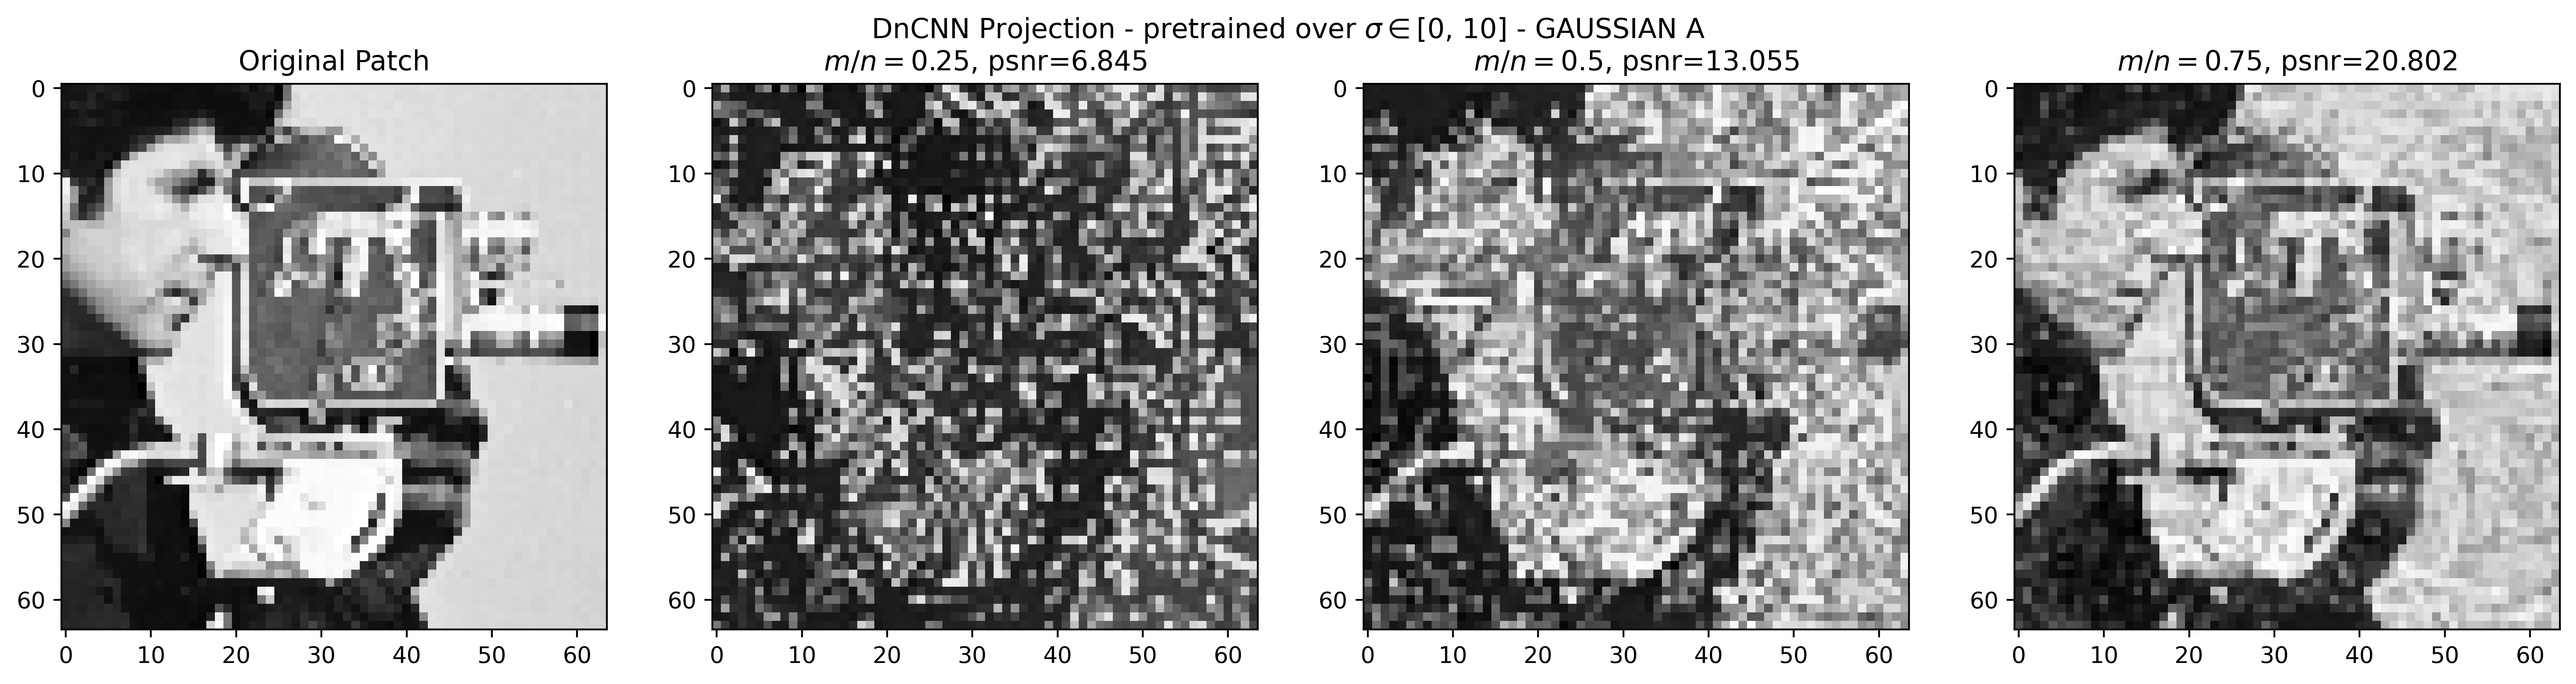

In [79]:
cs_dncnn(200, 'gaussian', 0.2, 10, bias_free=False)

100%|██████████| 200/200 [00:36<00:00,  5.49it/s, m/n=0.75, psnr_best=28, mse_best=0.00159, iter_best=199]


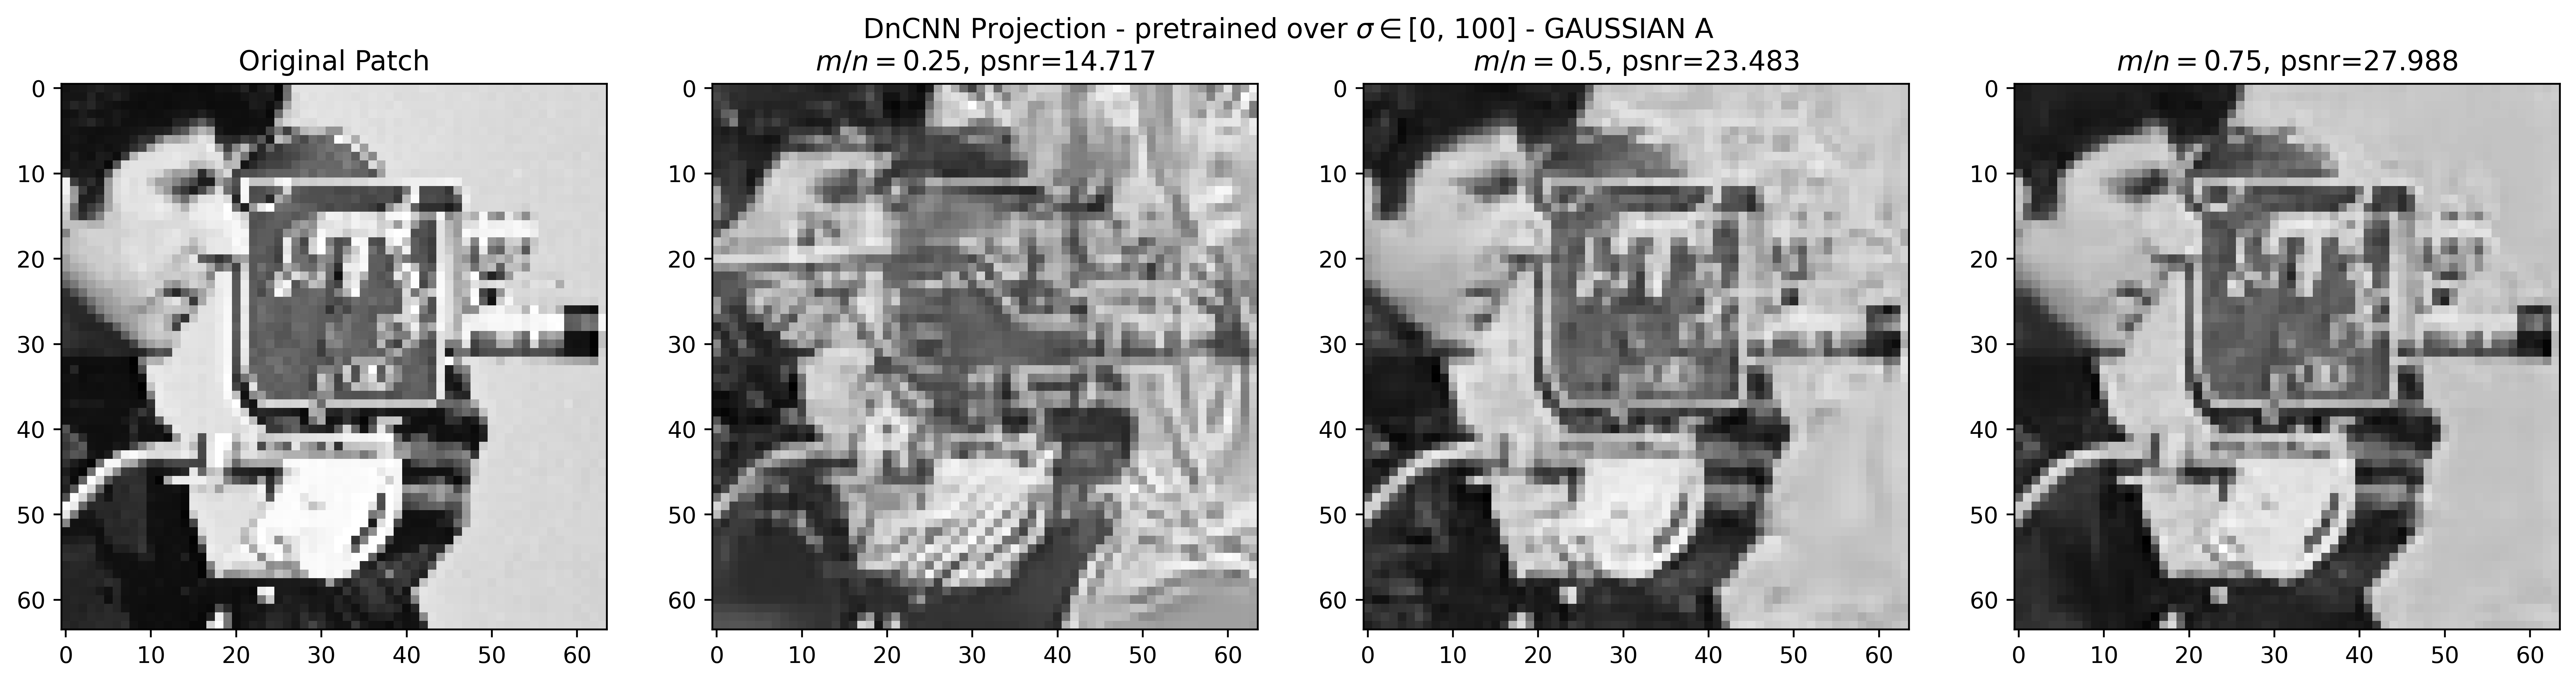

In [80]:
cs_dncnn(200, 'gaussian', 0.2, 100, bias_free=False)

## PnP with Pre-trained Blind Bias-Free DnCNN Denoiser

100%|██████████| 200/200 [00:48<00:00,  4.10it/s, m/n=0.75, psnr_best=36.9, mse_best=0.000204, iter_best=198]


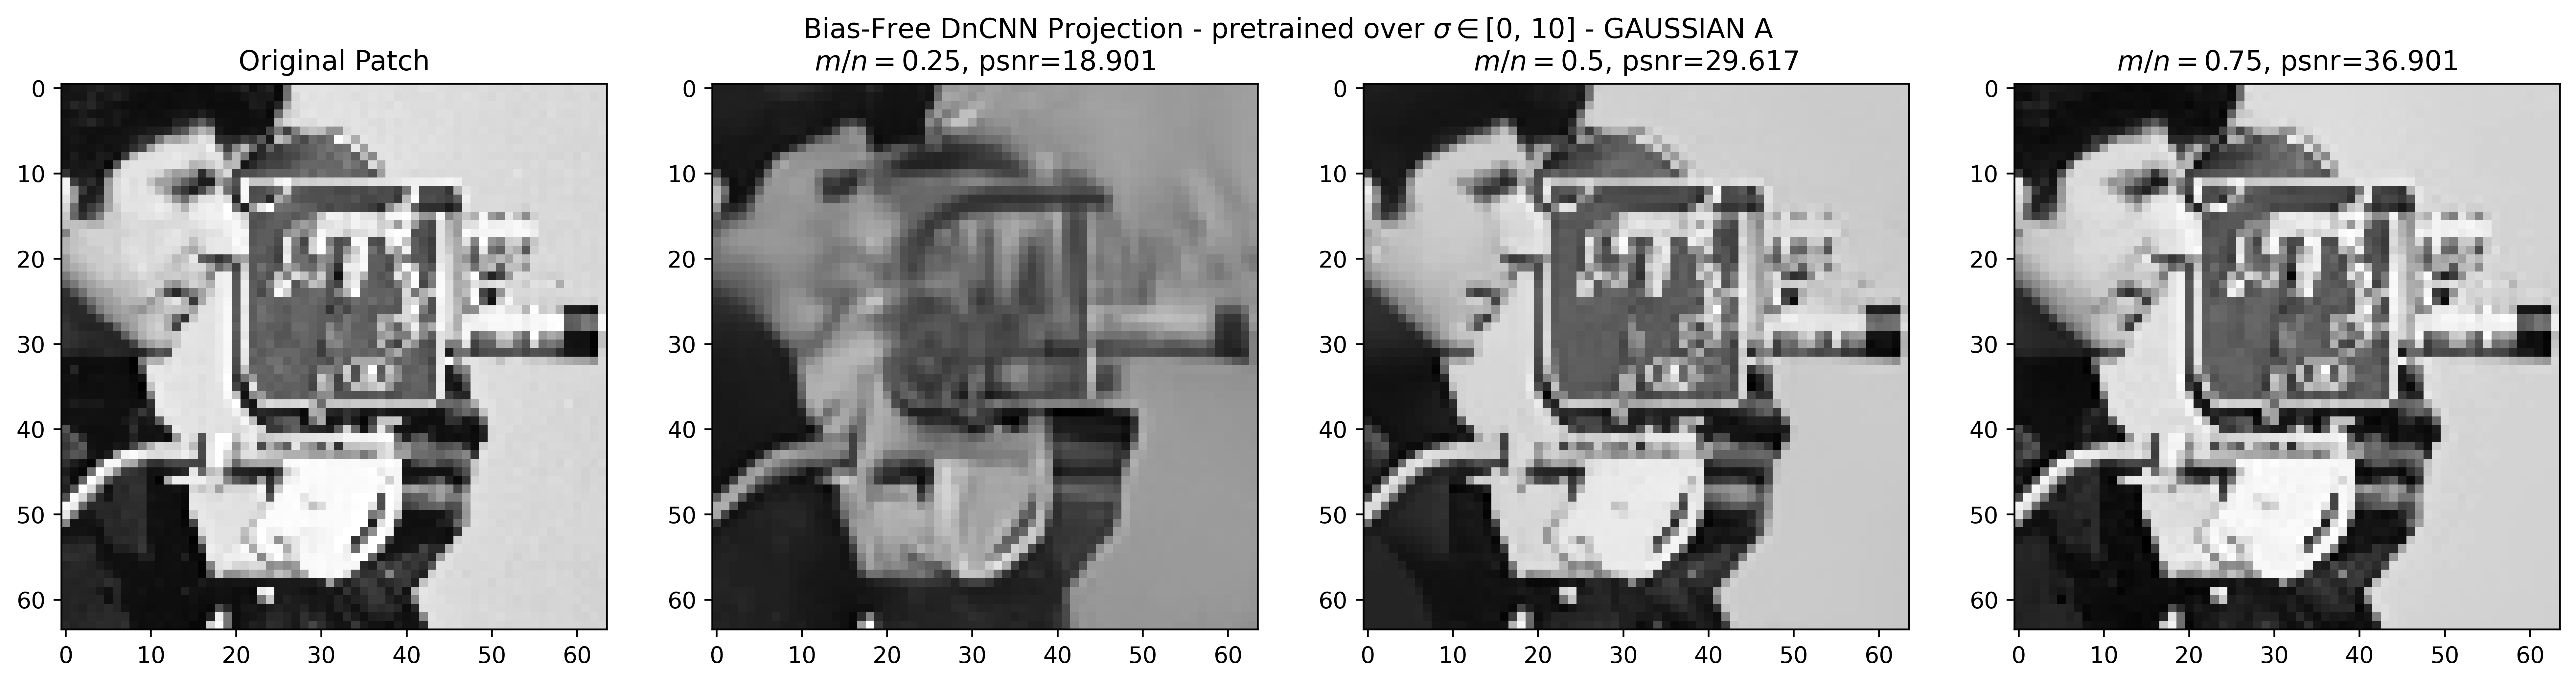

In [70]:
cs_dncnn(200, 'gaussian', 0.5, 10, bias_free=True)

100%|██████████| 200/200 [00:44<00:00,  4.49it/s, m/n=0.75, psnr_best=30.7, mse_best=0.000859, iter_best=86]


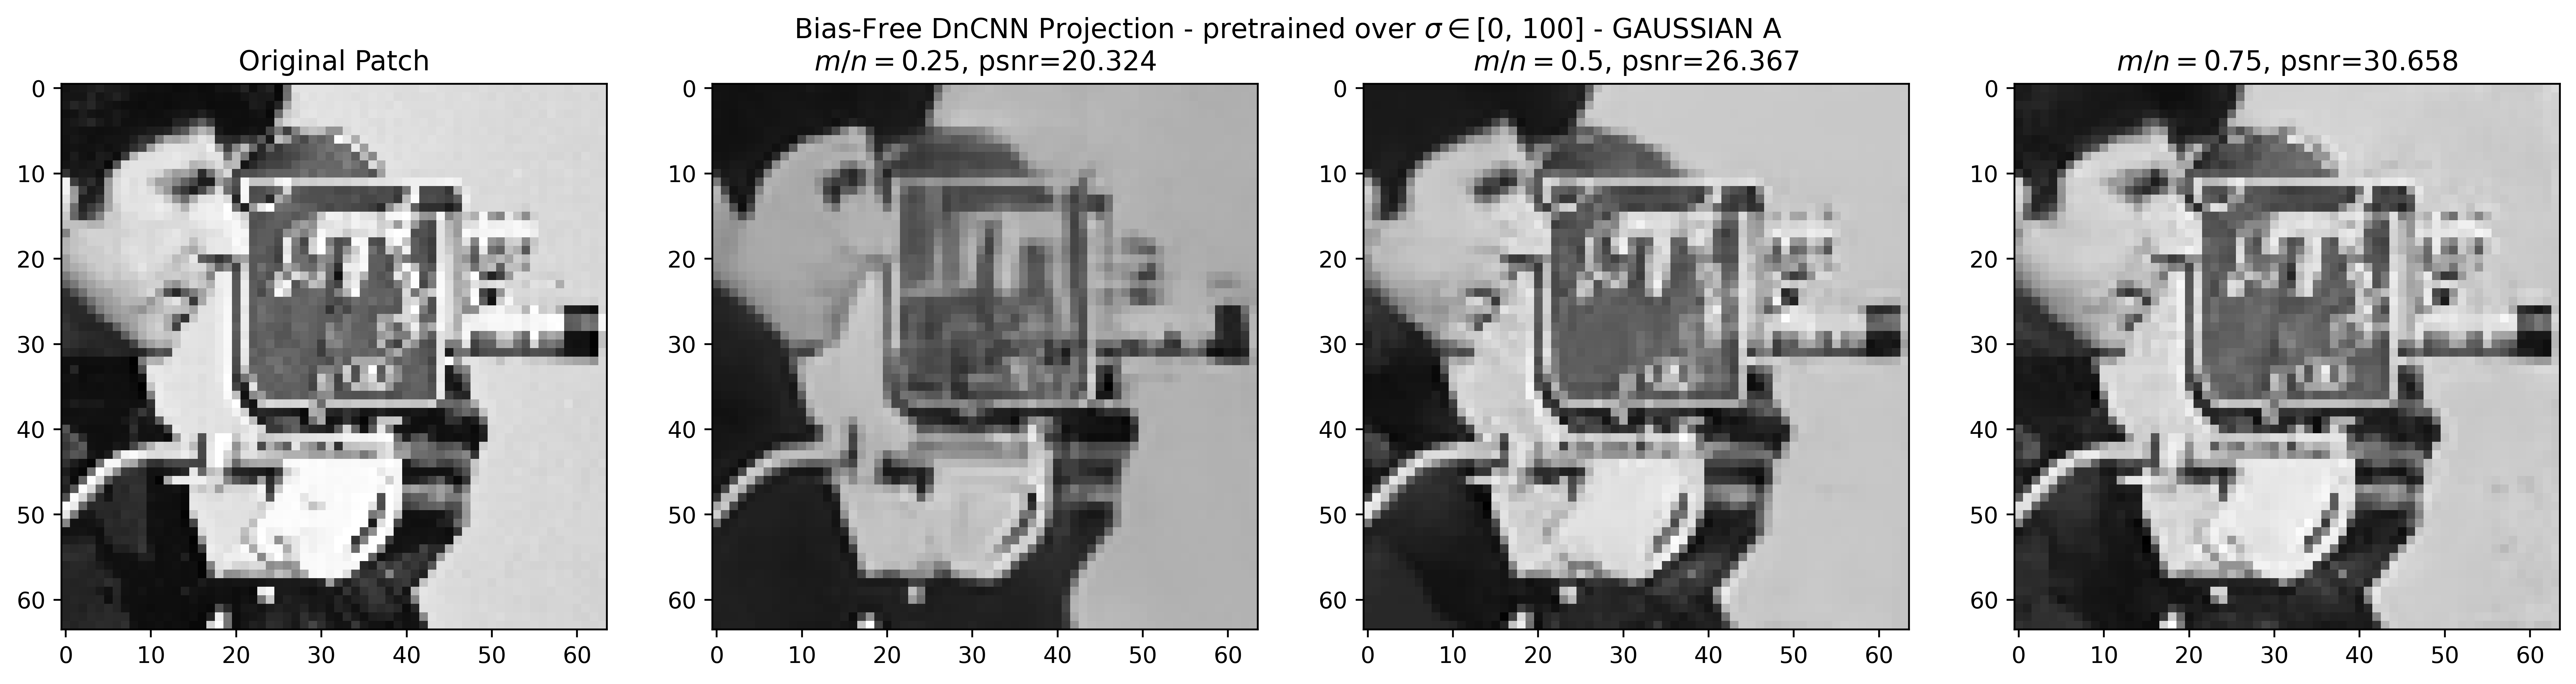

In [74]:
cs_dncnn(200, 'gaussian', 0.5, 100, bias_free=True)

## PnP with Untrained Blind DeepDecoder Denoiser

100%|██████████| 50/50 [07:41<00:00,  9.23s/it, m/n=0.75, psnr_best=19.3, mse_best=0.0118, iter_best=25]


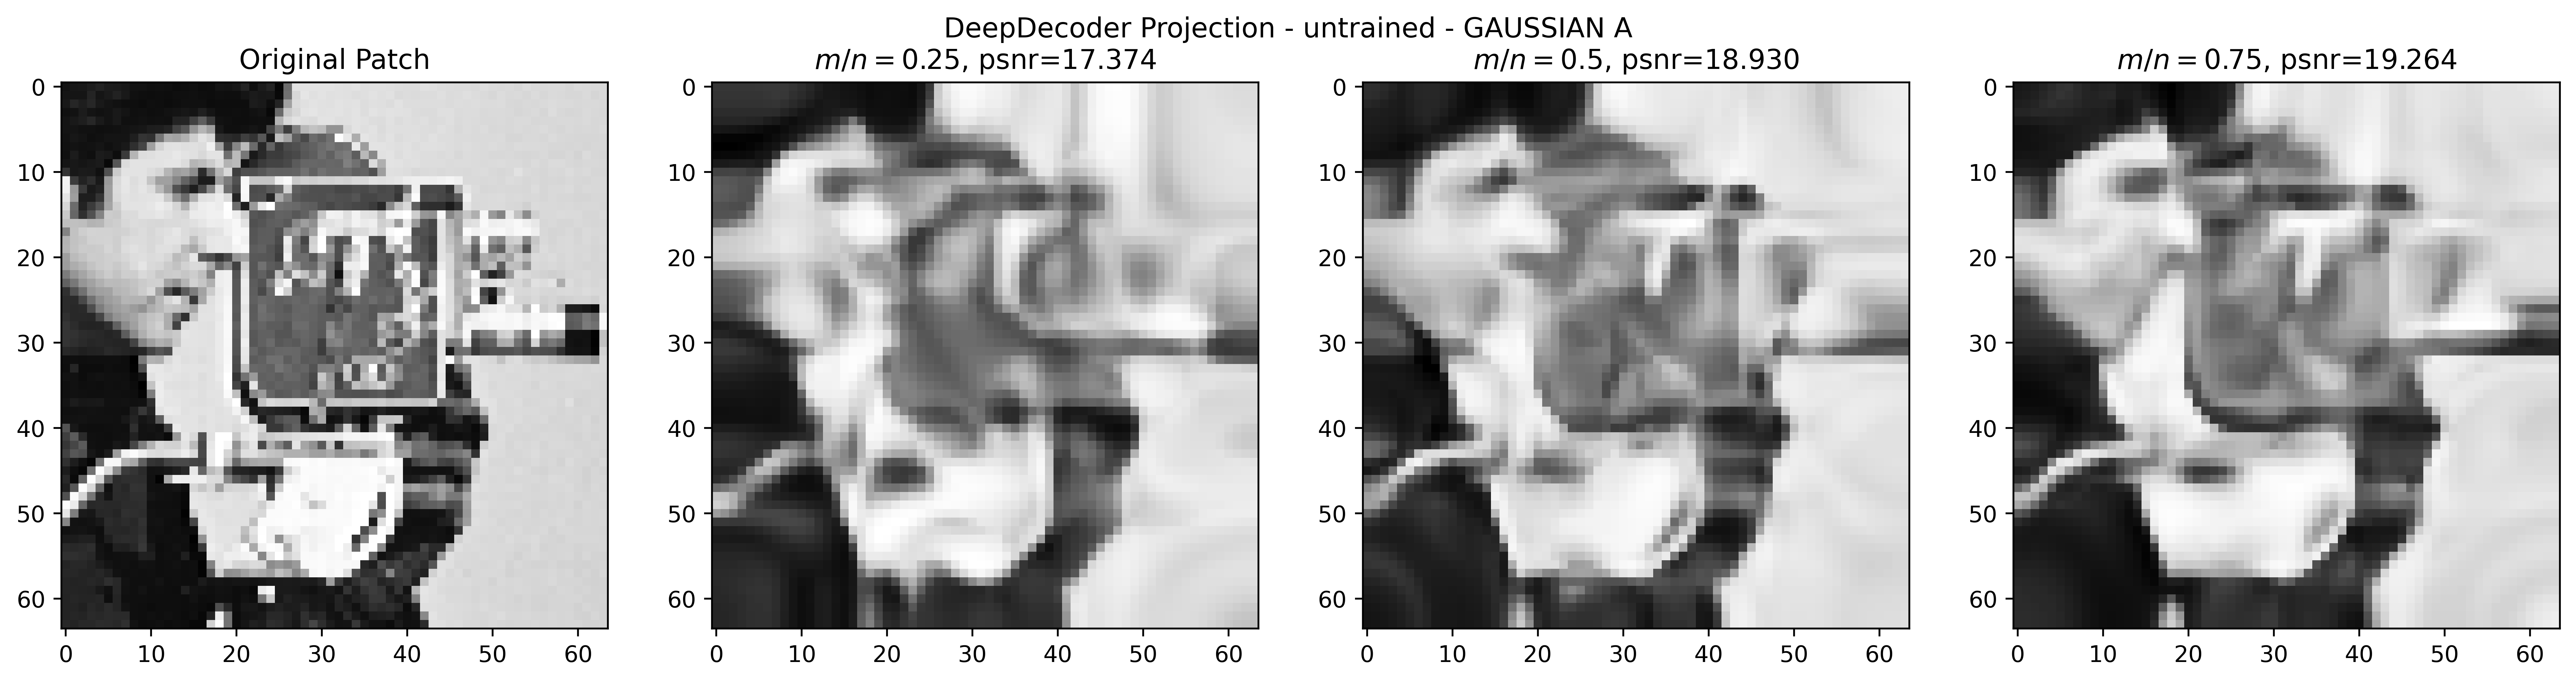

In [69]:
cs_deepdecoder(50, 'gaussian', 0.5)

## PnP with BM3D non-Blind Denoiser

100%|██████████| 100/100 [02:02<00:00,  1.23s/it, m/n=0.75, psnr_best=27.6, mse_best=0.00173, iter_best=99]


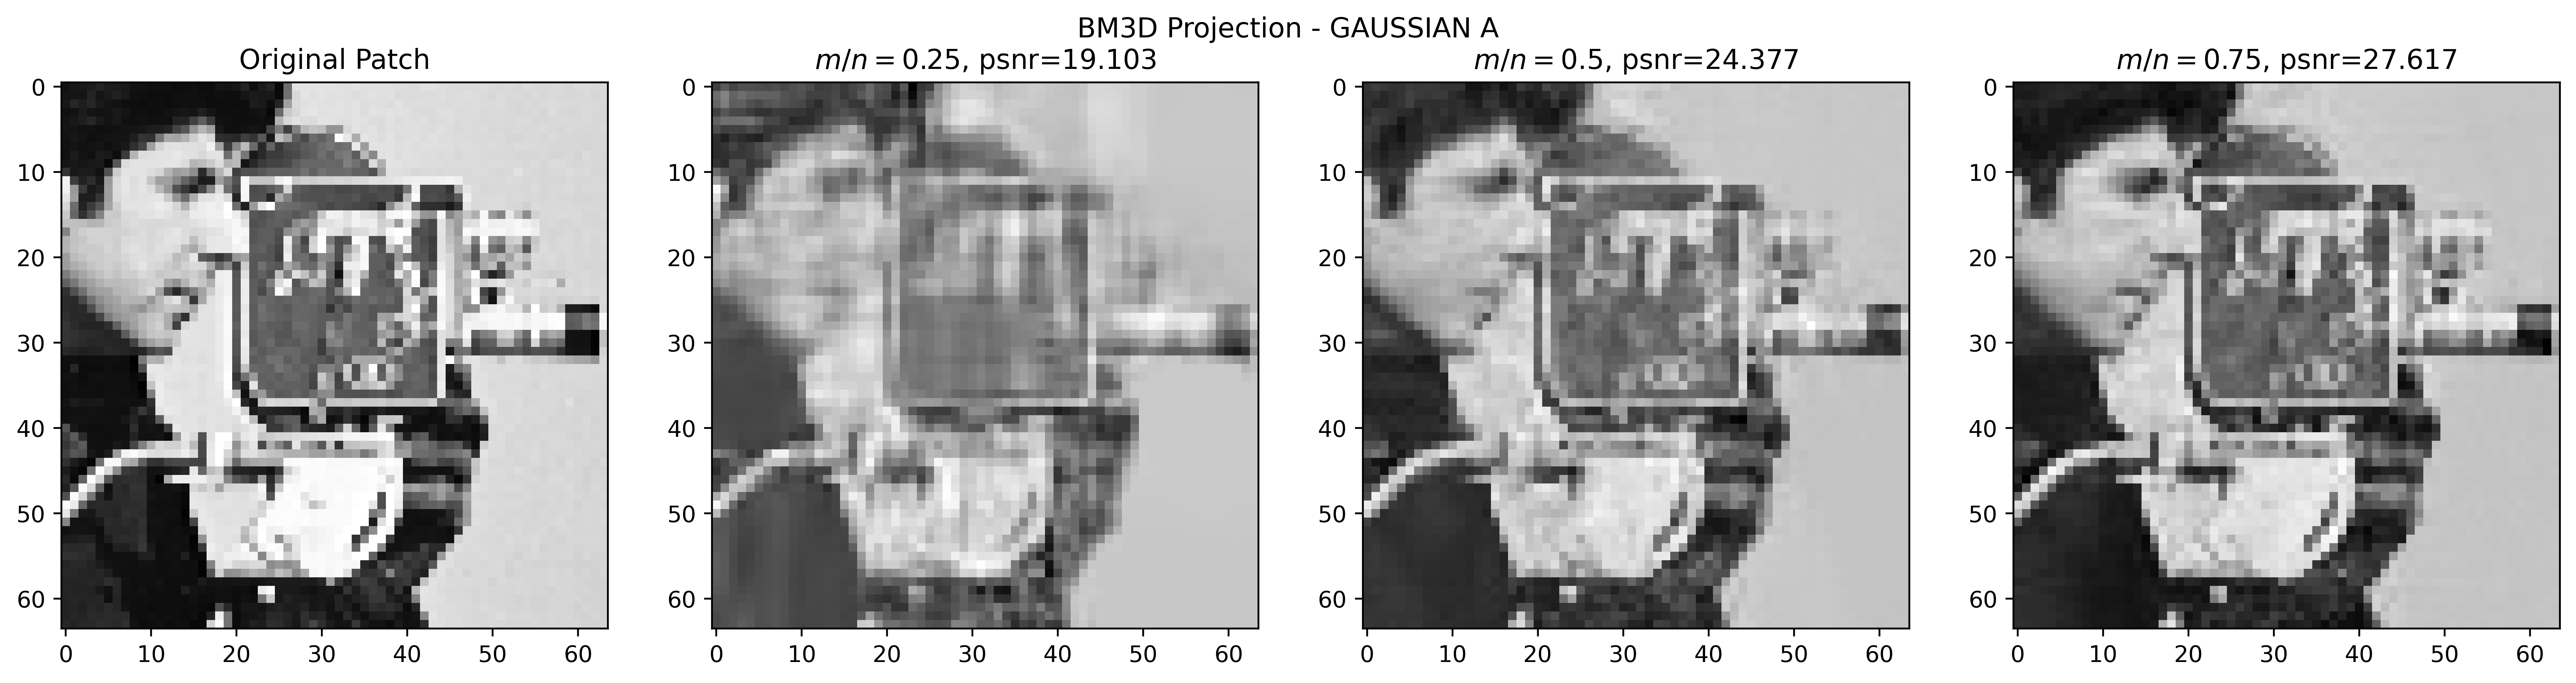

In [ ]:
cs_bm3d(100, 'gaussian', 0.5, 2, True)

## Plot PSNR as Function of m

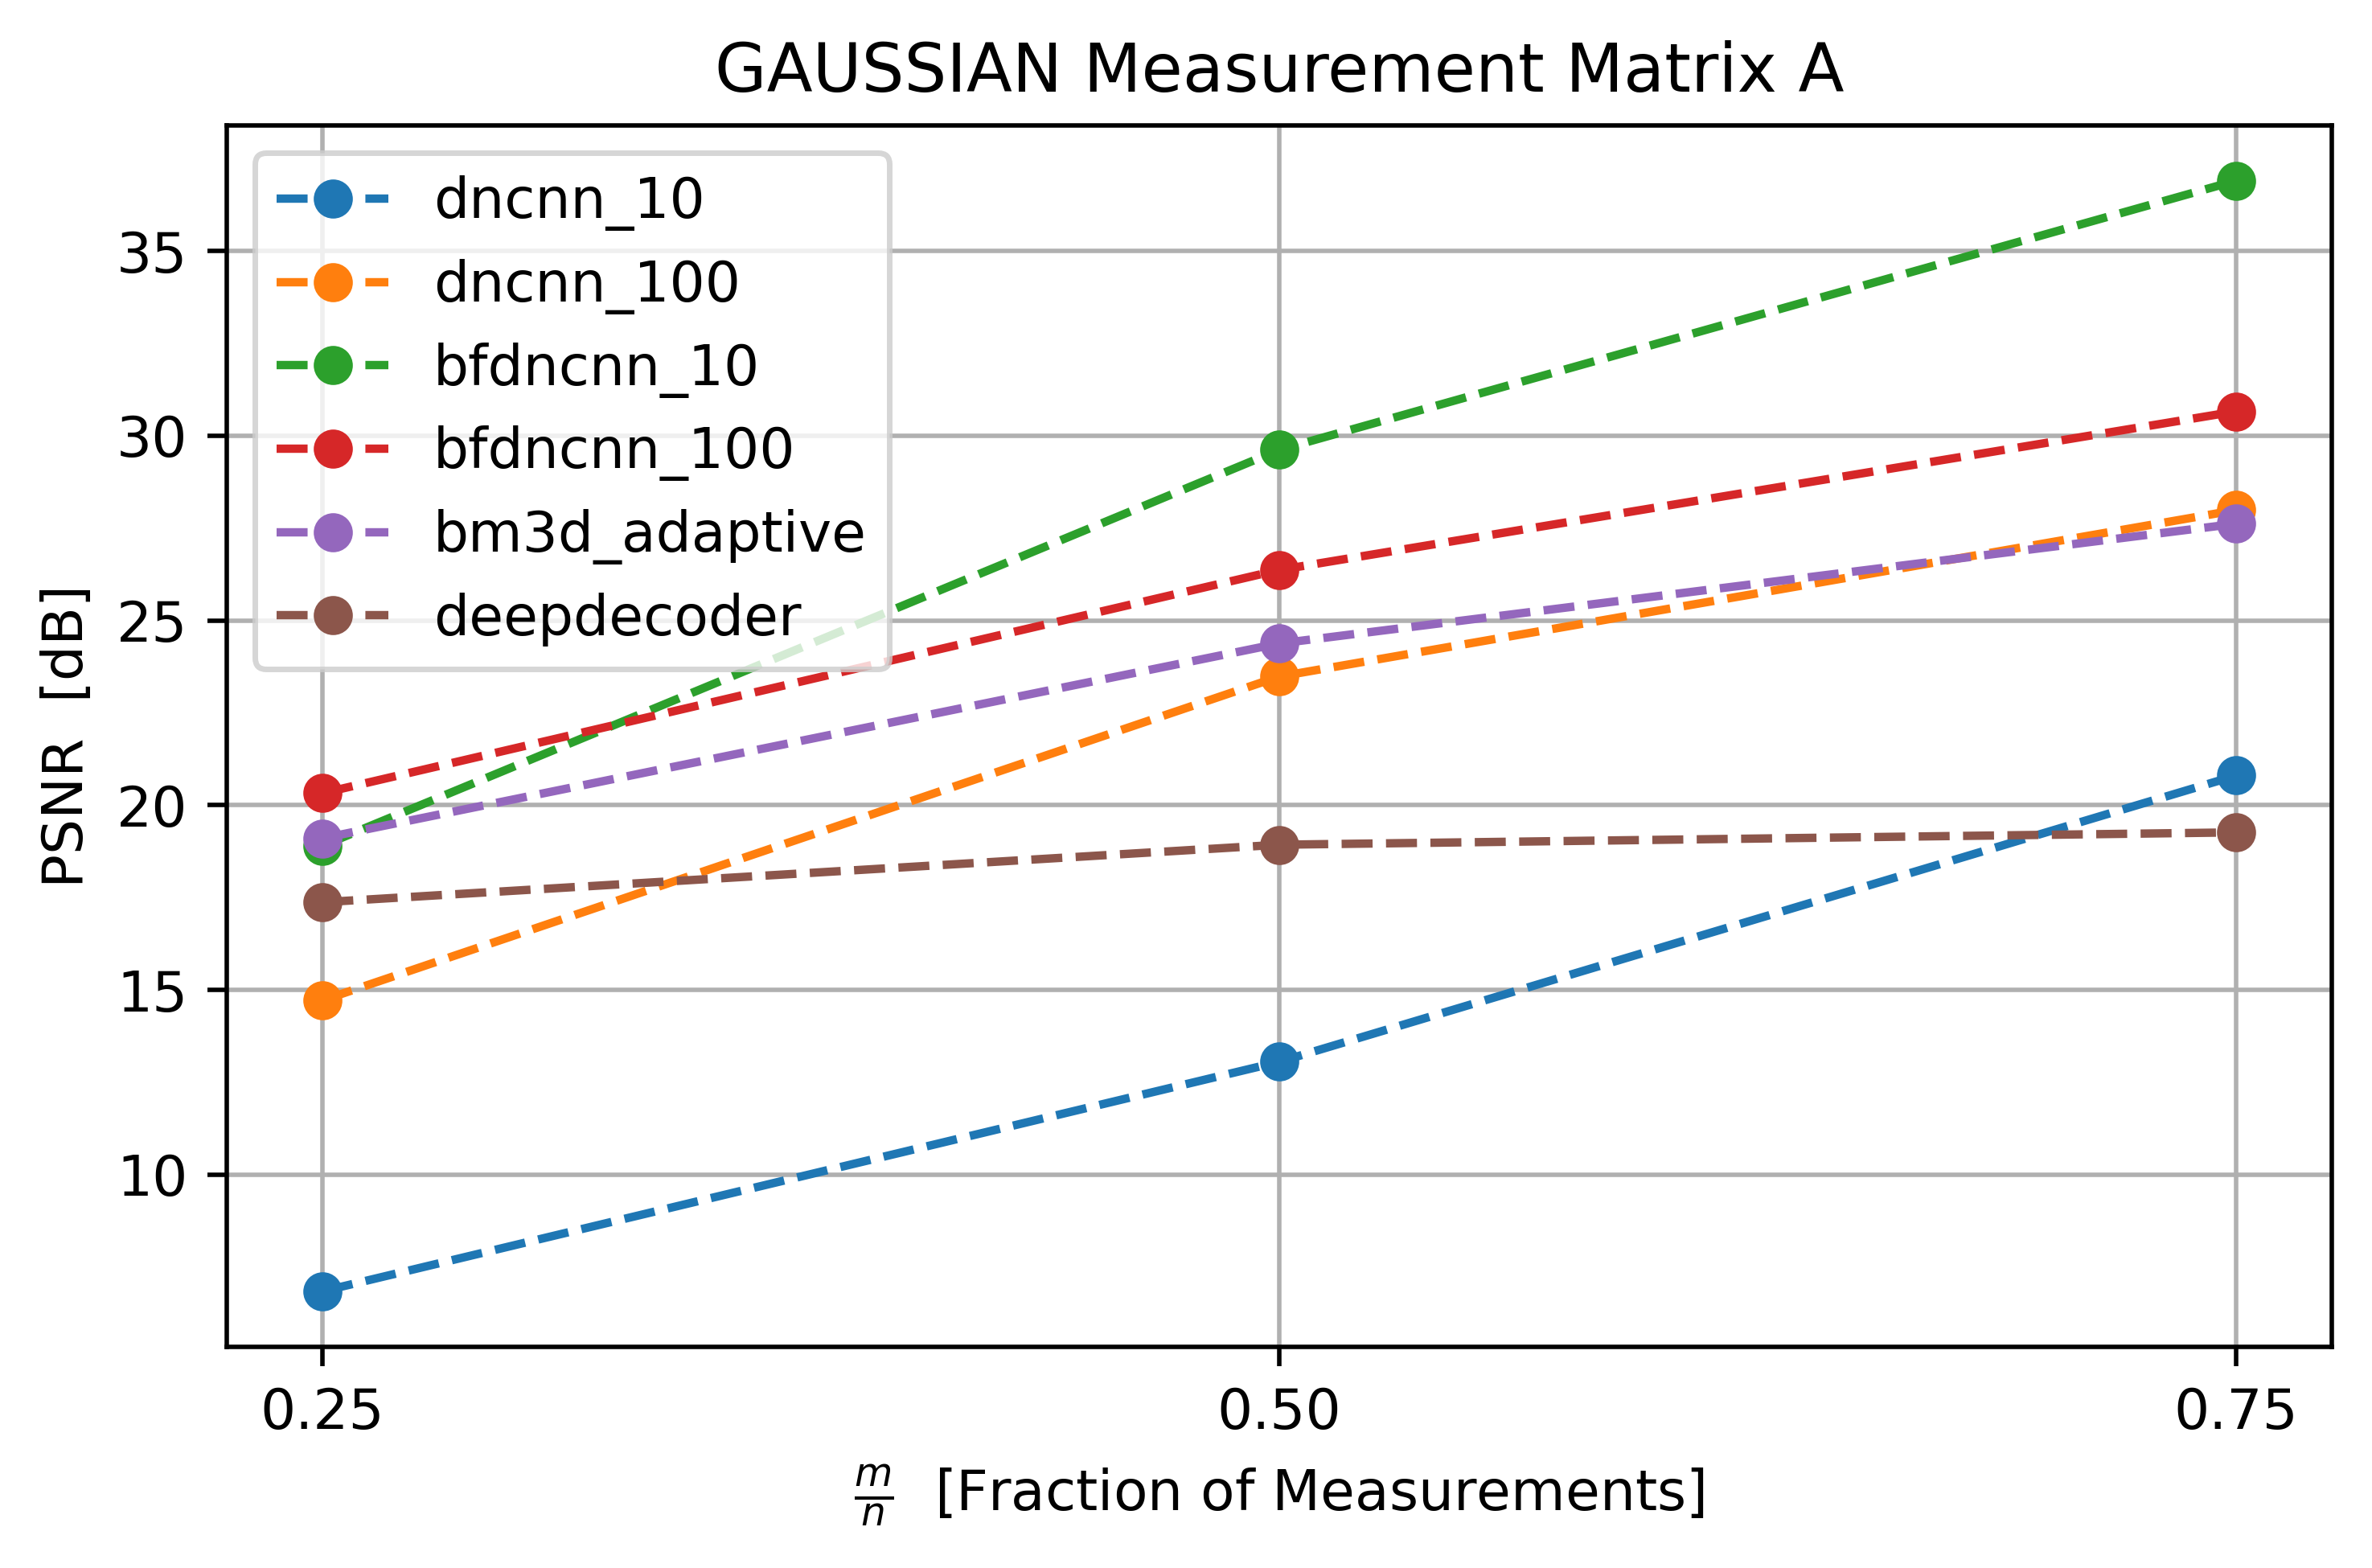

In [81]:
performance_plot('gaussian')

# DCT Measurement Matrix

## PnP with Pre-trained Blind DnCNN Denoiser

100%|██████████| 200/200 [00:36<00:00,  5.45it/s, m/n=0.75, psnr_best=27.6, mse_best=0.00174, iter_best=199]


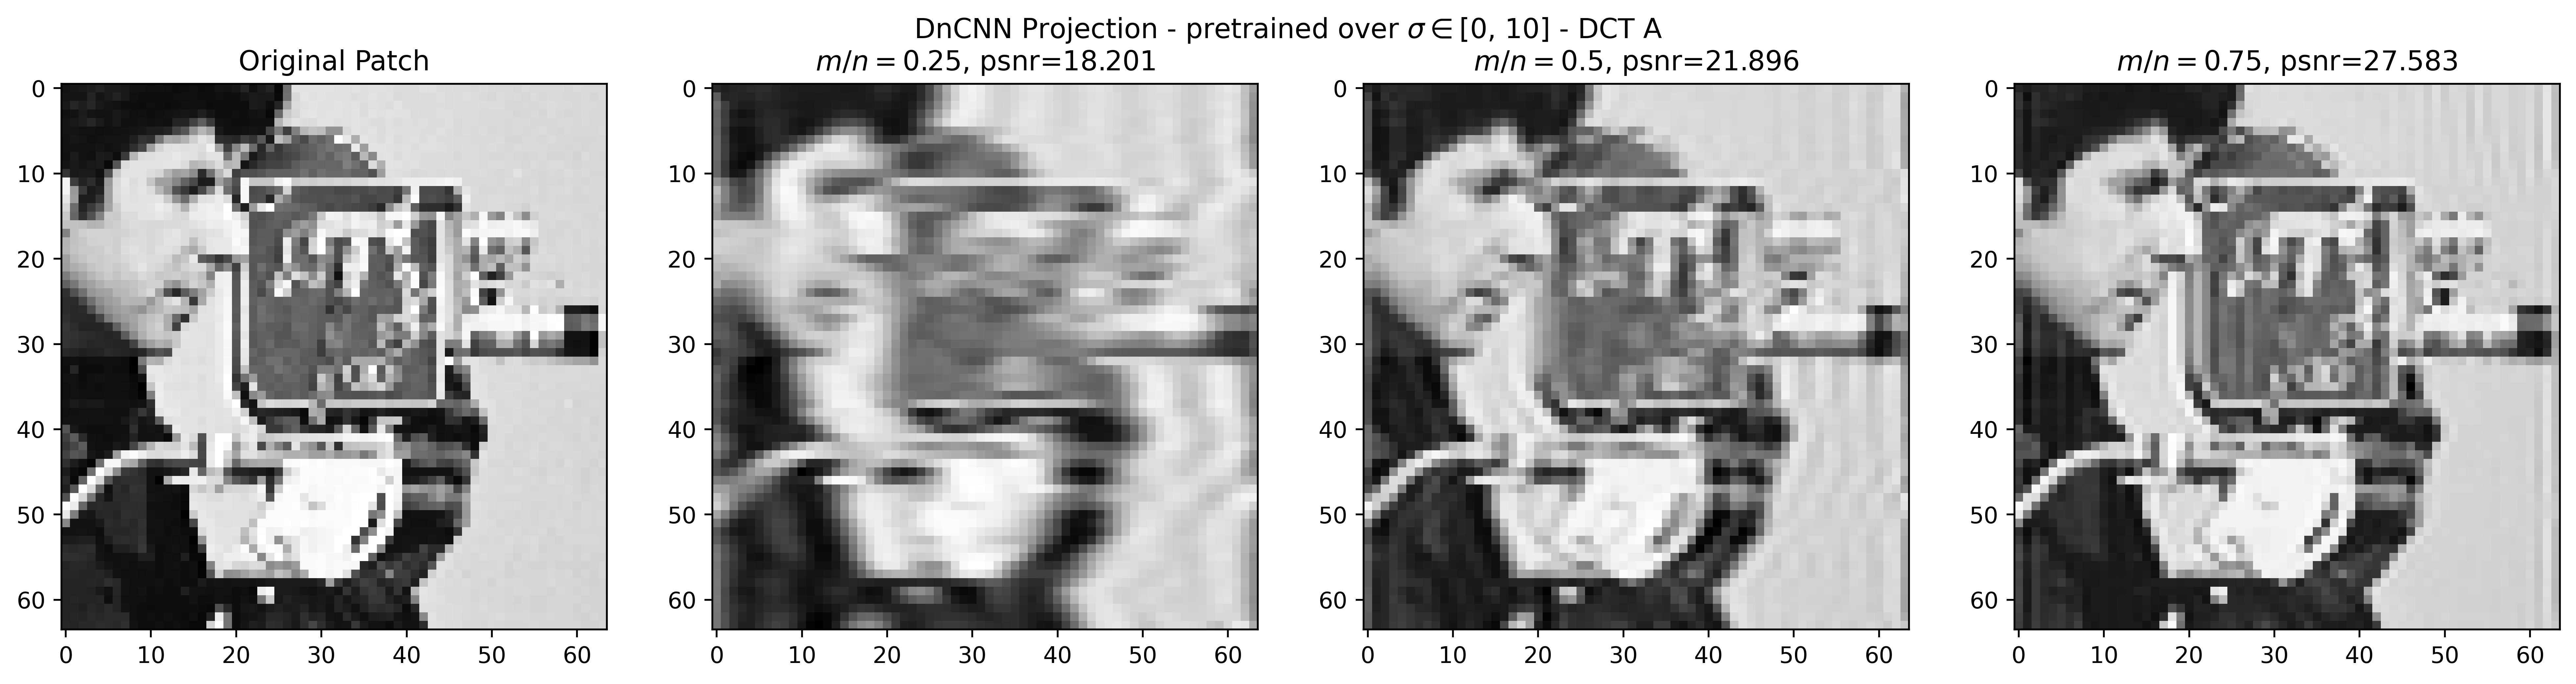

In [43]:
cs_dncnn(200, 'dct', 0.05, 10, bias_free=False)

100%|██████████| 200/200 [00:35<00:00,  5.63it/s, m/n=0.75, psnr_best=26.5, mse_best=0.00224, iter_best=184]


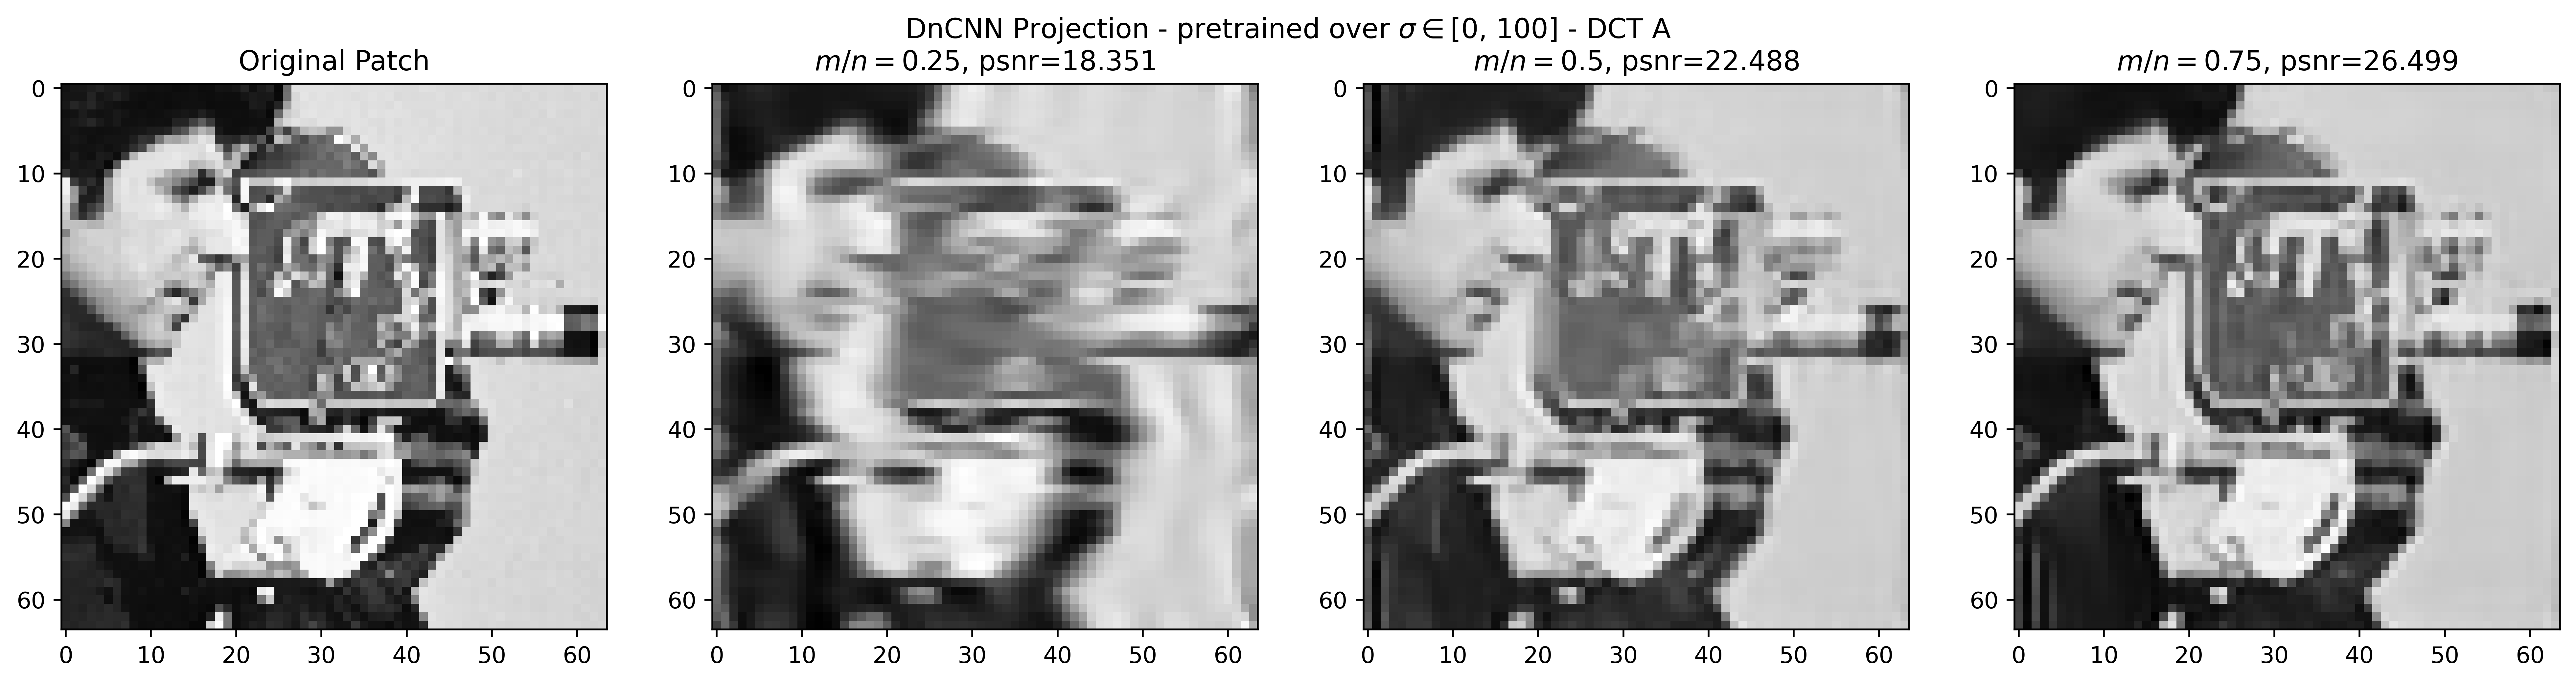

In [42]:
cs_dncnn(200, 'dct', 0.01, 100, bias_free=False)

## PnP with Pre-trained Blind Bias-Free DnCNN Denoiser

100%|██████████| 200/200 [00:46<00:00,  4.30it/s, m/n=0.75, psnr_best=25.6, mse_best=0.00278, iter_best=199]


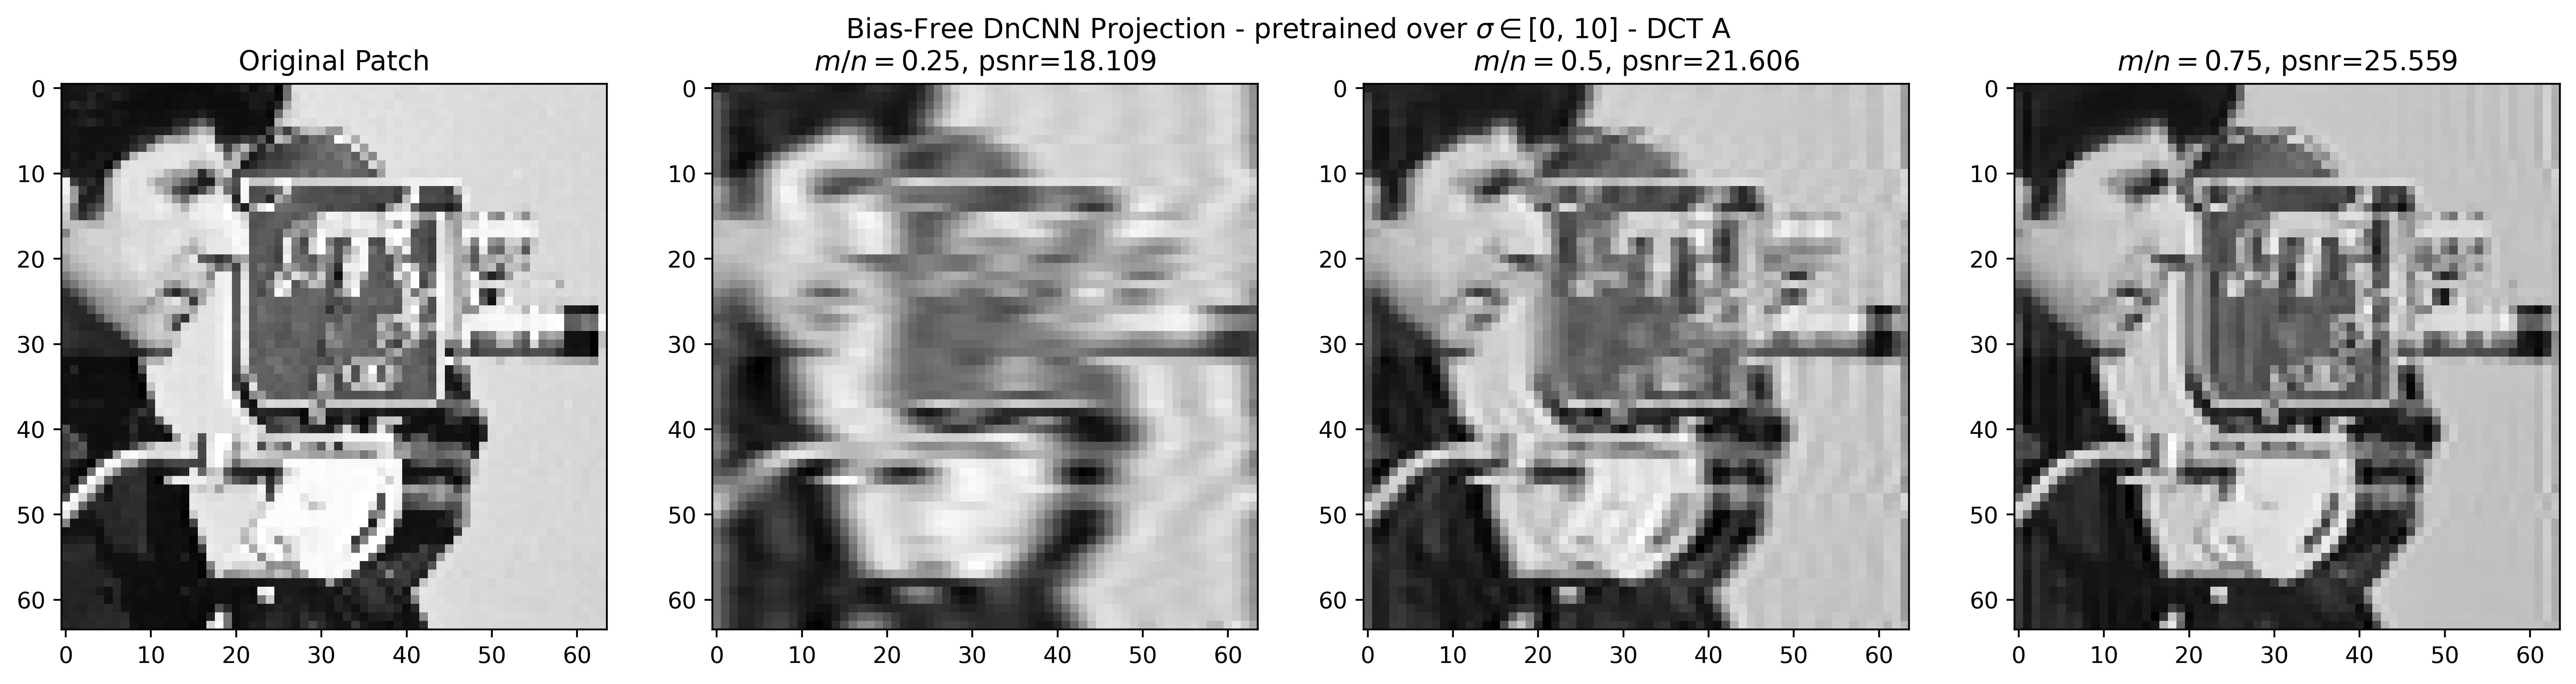

In [54]:
cs_dncnn(200, 'dct', 0.01, 10, bias_free=True)

100%|██████████| 200/200 [00:47<00:00,  4.22it/s, m/n=0.75, psnr_best=22.7, mse_best=0.00539, iter_best=188]


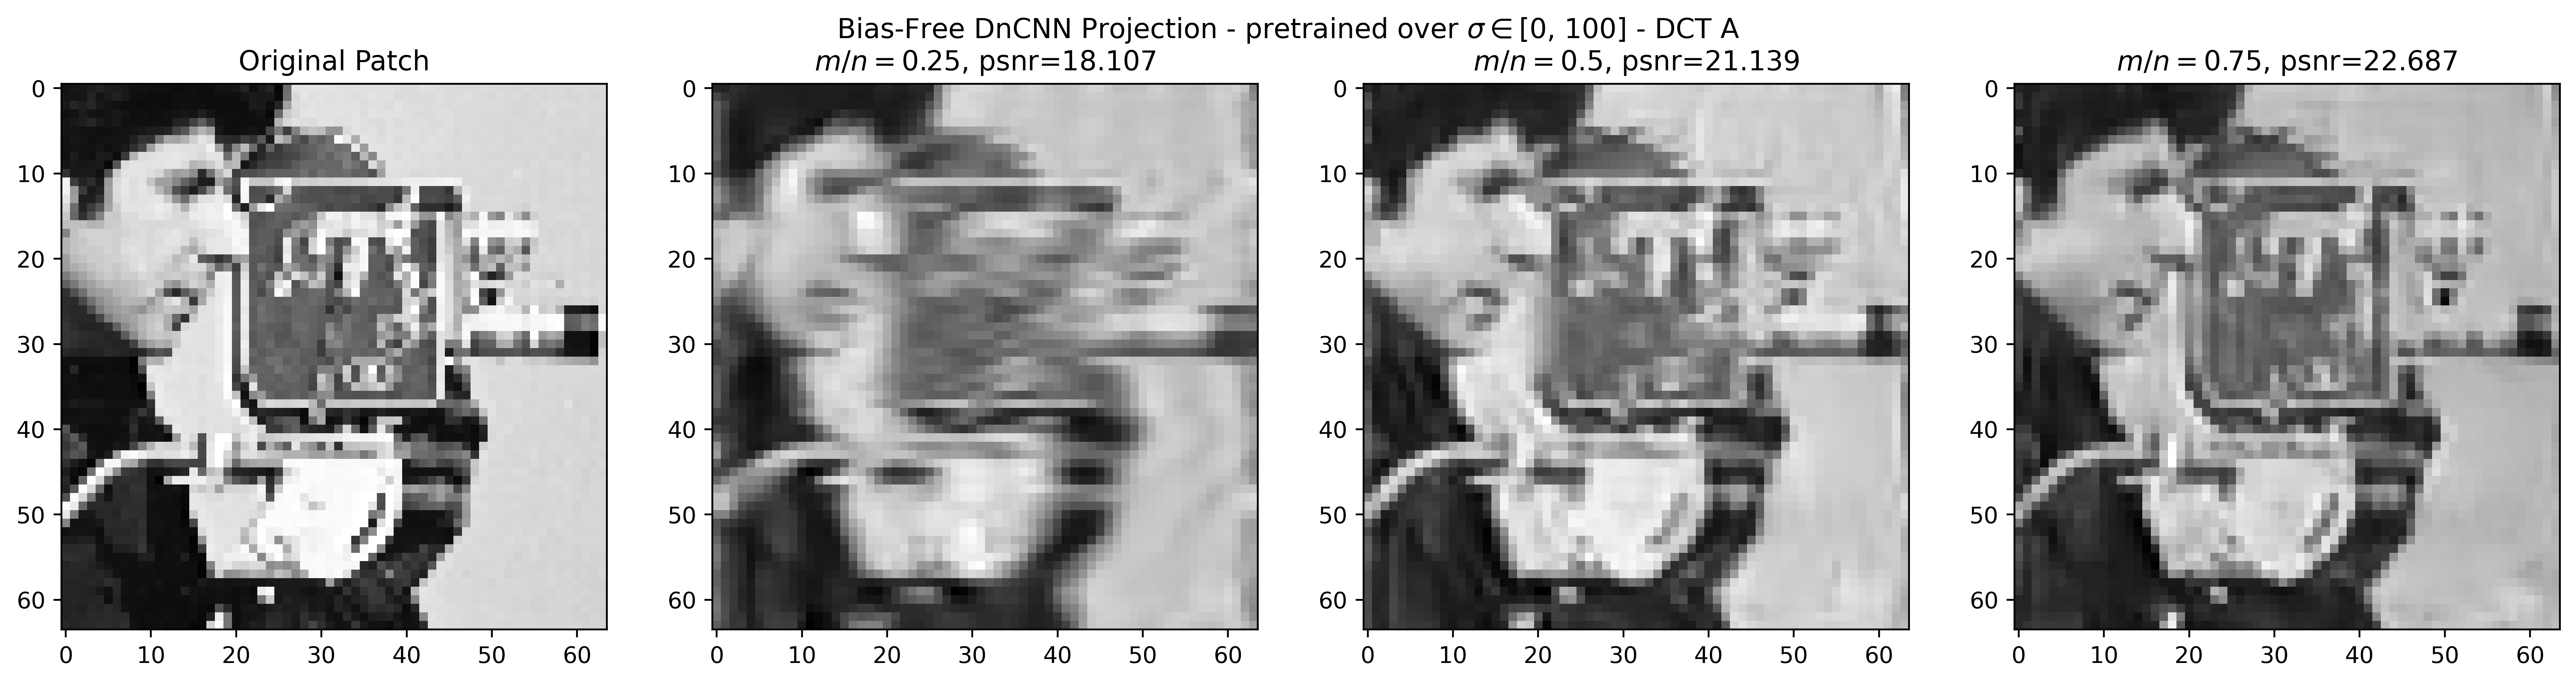

In [60]:
cs_dncnn(200, 'dct', 0.01, 100, bias_free=True)

## PnP with Untrained Blind DeepDecoder Denoiser

100%|██████████| 50/50 [07:32<00:00,  9.05s/it, m/n=0.75, psnr_best=19.4, mse_best=0.0115, iter_best=14]


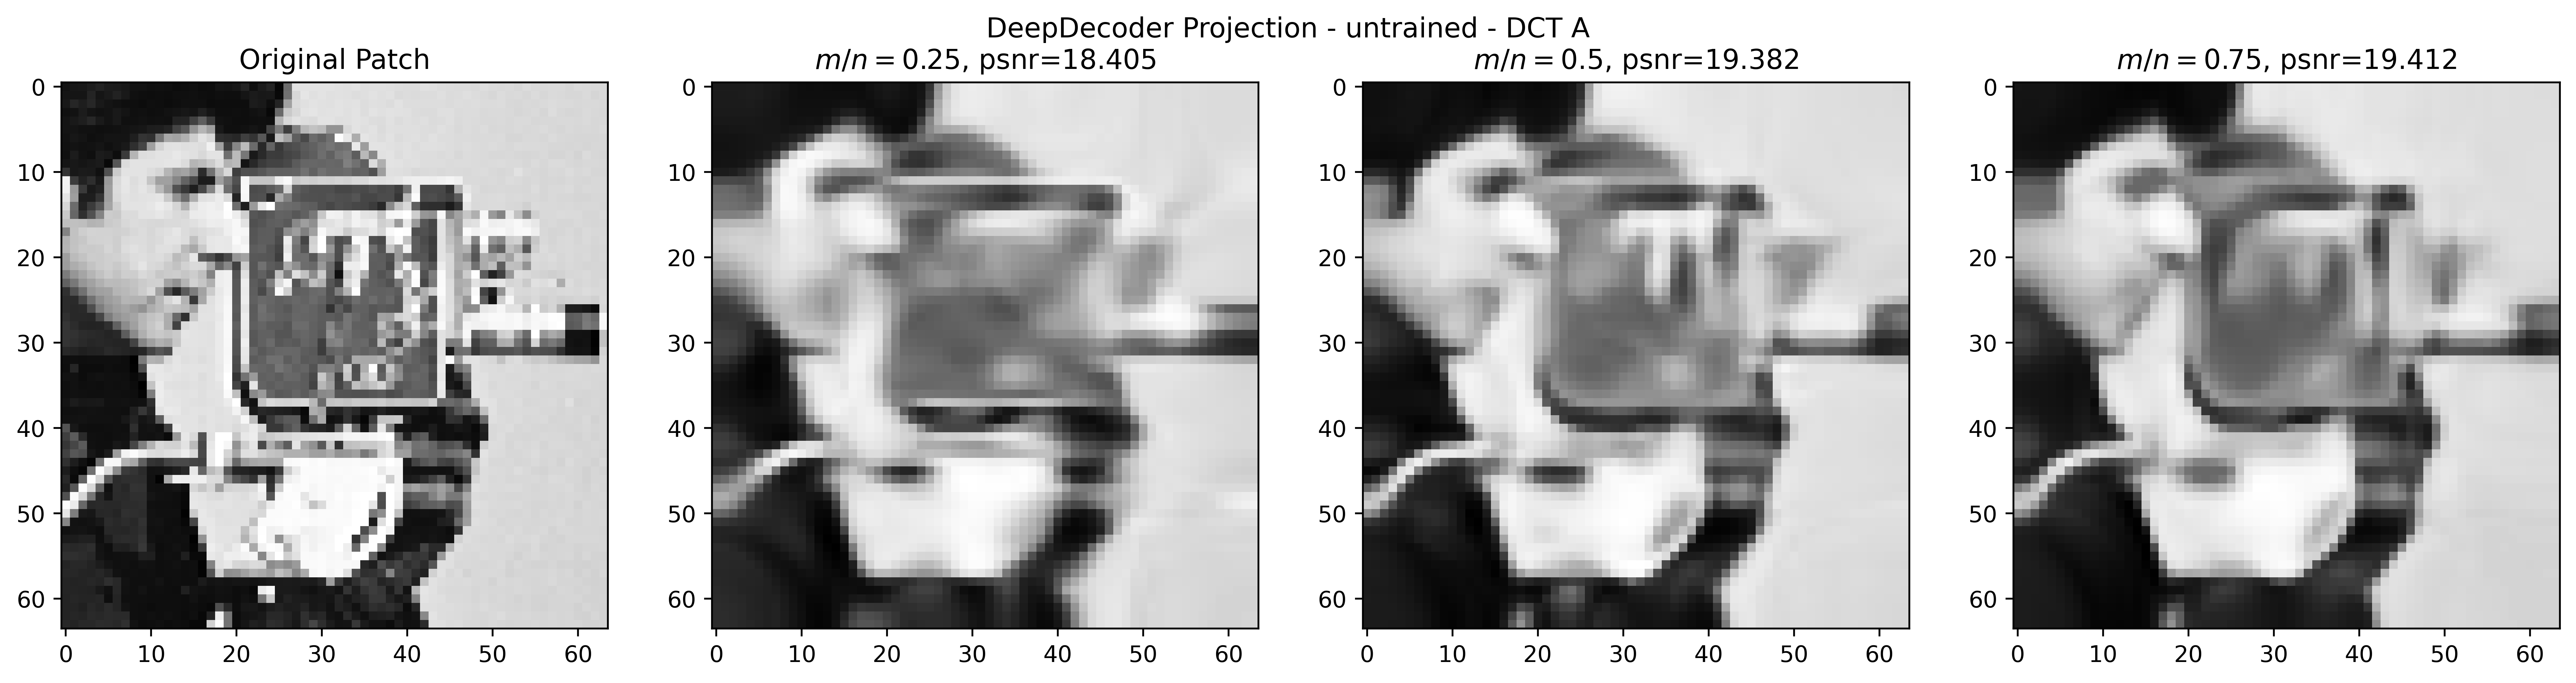

In [62]:
cs_deepdecoder(50, 'dct', 0.2)

## PnP with BM3D non-Blind Denoiser

100%|██████████| 100/100 [01:48<00:00,  1.09s/it, m/n=0.75, psnr_best=25.8, mse_best=0.00261, iter_best=99]


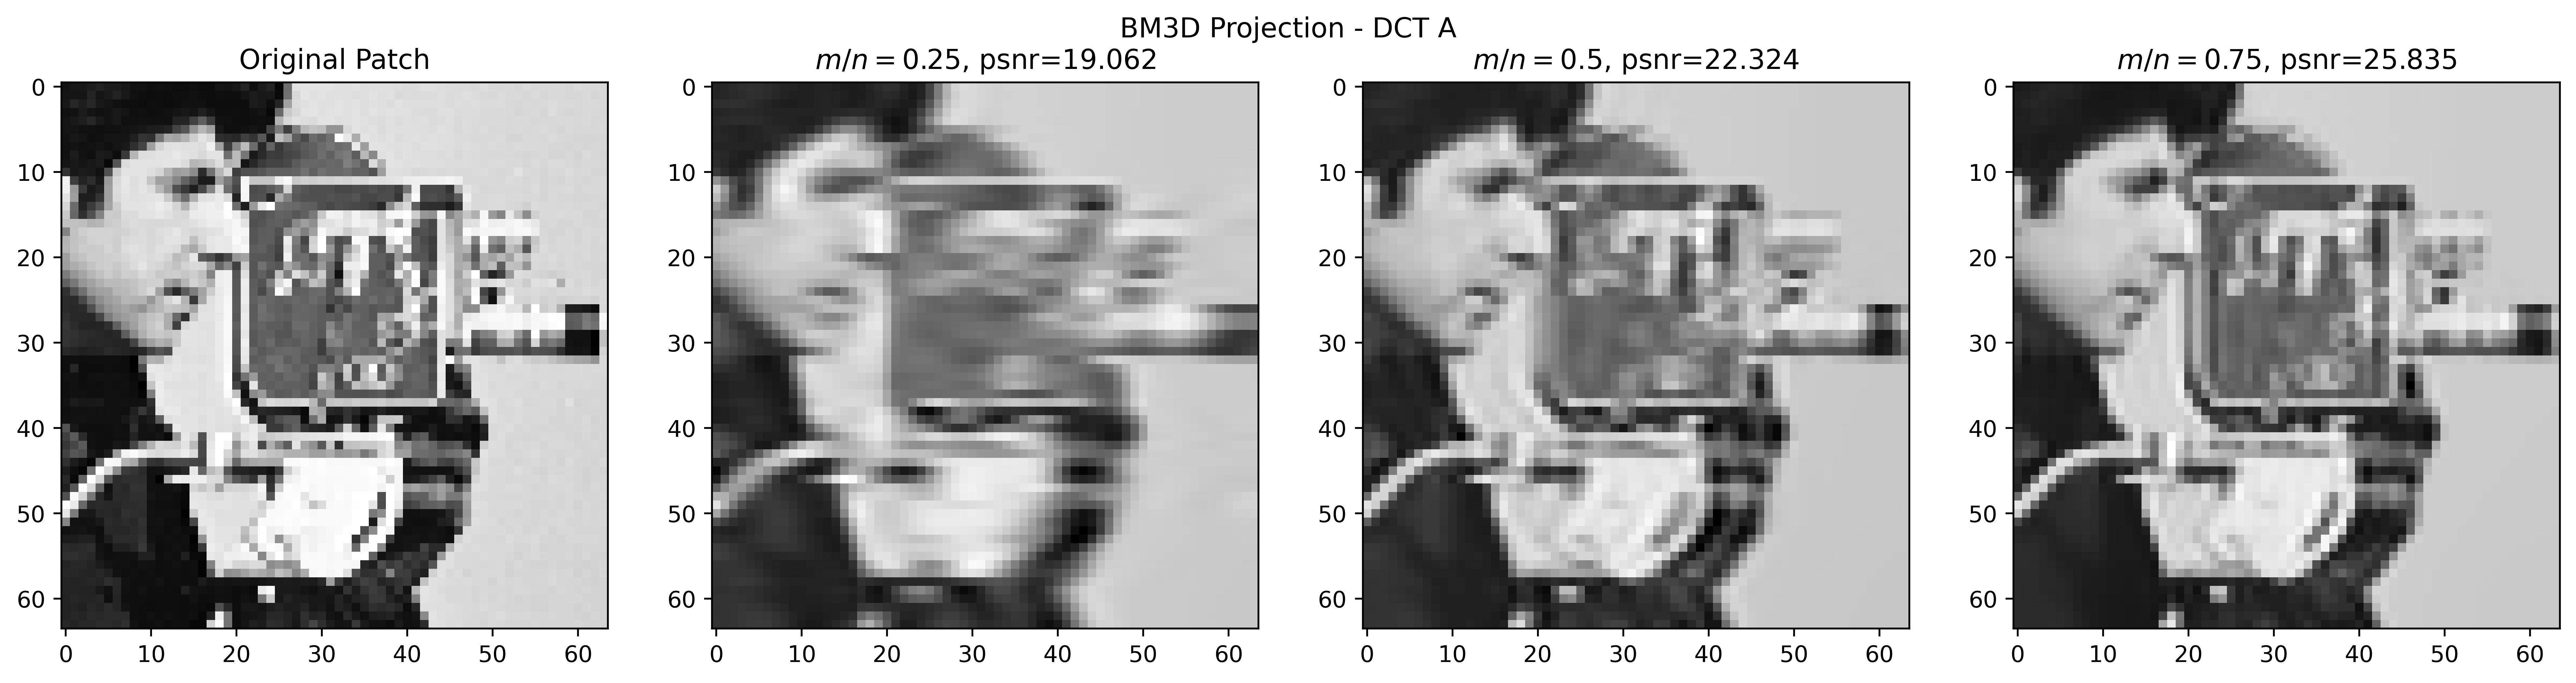

In [58]:
cs_bm3d(100, 'dct', 0.2, 2, True)

## Plot PSNR as Function of m

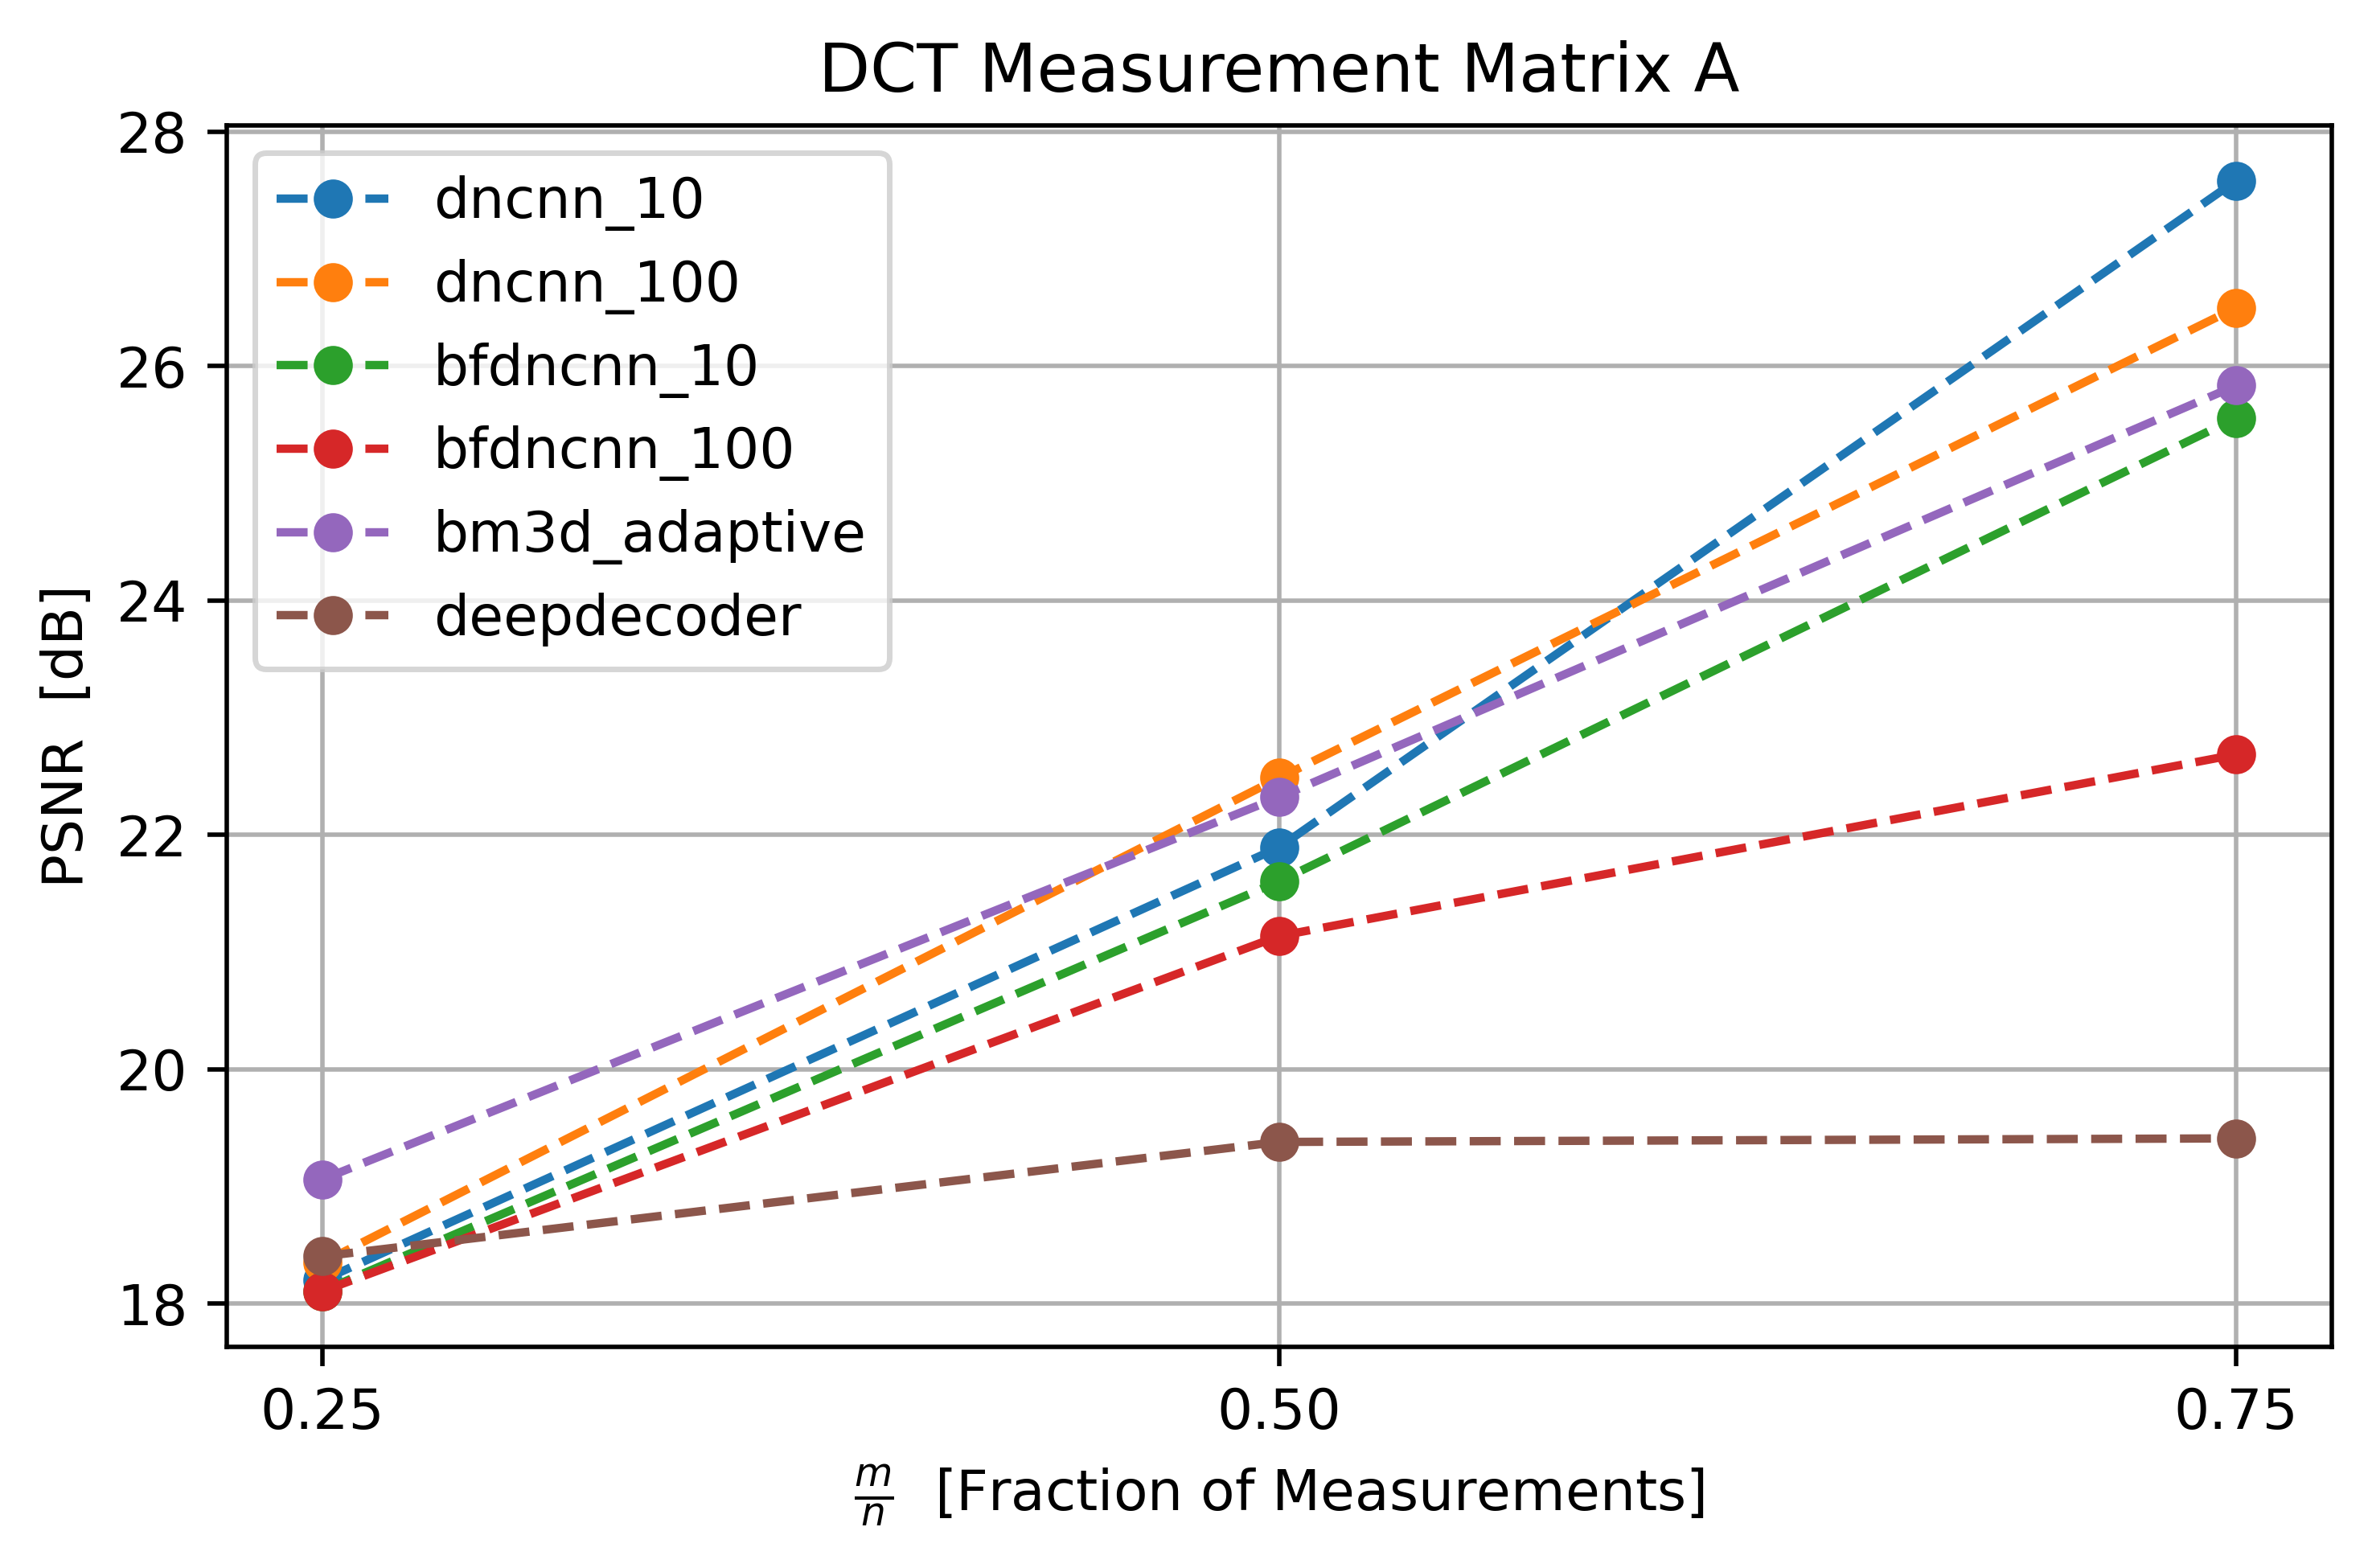

In [63]:
performance_plot('dct')